First try reconstructing these spectra with an autoencoder.  Just because I already have code in hand for that.

In [6]:
def isNaN(string):
    return string != string

In [7]:
from sklearn.decomposition import NMF

from astropy.io import fits
from astropy.table import Table
from astropy.io.fits import Column
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import richardsplot
import os

In [8]:
dat = pd.read_csv("../data/ParentSample_DR7props.csv")
dat.head()

A_morph           SDSS_NAME          RA        DEC  REDSHIFT  PLATE  FIBER  \
0       D  093509.48+481910.2  143.789520  48.319504    0.2238    834    361   
1       E  152925.98+021646.6  232.358261   2.279618    0.2634   2954    379   
2       E  144414.66+063306.7  221.061111   6.551877    0.2080   1829    464   
3       E  140808.19+430316.5  212.034164  43.054600    0.2581   1467     48   
4       E  172711.80+632242.1  261.799194  63.378372    0.2174    352    639   

     MJD  TARGET_FLAG_TARGET  NSPECOBS  ...    f_c   logL     i_2   I_2a  \
0  52316                7691         1  ...  1.000  22.92  17.026 -22.73   
1  54561                   3         1  ...  1.000  22.47  17.490 -22.61   
2  53494           135273475         1  ...  1.000  22.47  16.552 -23.04   
3  53115                7171         1  ...  1.000  22.99  16.922 -23.14   
4  51789                7168         2  ...  1.000  22.97  16.730 -22.95   

      R         LD_cm       Lobs   L_1.4GHz  SFR (Msun/yr)  Separation  
0  1.07  3.434469e+27  22.949804  23.453667     167.694491         0.0  
1  0.41  4.120027e+27  22.510854  23.024252      62.388456         0.0  
2  0.29  3.160119e+27  22.505157  23.005020      59.685944         0.0  
3  0.85  4.030828e+27  23.028500  23.540693     204.901363         0.0  
4  0.99  3.313937e+27  23.002030  23.504149     188.365559         0.0  

[5 rows x 163 columns]

In [9]:
train = pd.read_csv("../data/trainsample_dr7_zlt0.358.csv")
train.head()

Unnamed: 0              SDSS_NAME        RA        DEC  REDSHIFT  PLATE  \
0          48  b'000102.18-102326.9'  0.259118 -10.390822    0.2943    650   
1          81  b'000149.52-100251.8'  0.456358 -10.047724    0.3578    650   
2         157  b'000410.80-104527.1'  1.045027 -10.757537    0.2397    650   
3         233  b'000557.23+002837.7'  1.488499   0.477143    0.2596    388   
4         235  b'000601.82-052845.0'  1.507606  -5.479184    0.3295   2630   

   FIBER    MJD  
0    166  52143  
1    152  52143  
2     18  52143  
3    385  51793  
4    149  54327

In [10]:
sdss_name_full = train["SDSS_NAME"].values
z_full         = train["REDSHIFT"].values
plate_full     = train["PLATE"].values
mjd_full       = train["MJD"].values
fiber_full     = train["FIBER"].values

In [11]:
#Will want to save homogeneous arrays of each QSO's wavelength, flux, and inverse variance
names   = []
spectra = []
wave    = []
ivar    = []
found   = [] #save dataframe indices which have spectra
N = 0

for sdss_name, red, pl, mj, fib in zip(sdss_name_full, z_full, plate_full, mjd_full, fiber_full):
    try:
        hdul_spec = fits.open("../data/spectra/train/zlt0p6_dr7/lite/%04d/spec-%04d-%05d-%04d.fits" % (pl,pl,mj,fib))
    except FileNotFoundError:
        #print("../data/spectra/train/zlt0p6_dr7/lite/%04d/spec-%04d-%05d-%04d.fits NOT FOUND" % (pl,pl,mj,fib))
        continue
        
        
    #Load in data from each FITS file
    sdss_flux   = hdul_spec[1].data["flux"]
    sdss_loglam = hdul_spec[1].data["loglam"]
    sdss_wave   = 10.**(sdss_loglam) / (1+red)  #x-axis: wavelength
    sdss_ivar   = hdul_spec[1].data["ivar"]
    
    #Want the same wavelength range for each array
    wavemask   = ((sdss_wave>=4000) & (sdss_wave<=6750)) #include Halpha
    sdss_flux  = sdss_flux[wavemask]
    #sdss_flux /= np.median(sdss_flux) #normalize spectrum
    sdss_ivar  = sdss_ivar[wavemask]
    sdss_wave  = sdss_wave[wavemask]
    hdul_spec.close()
    
    if len(sdss_flux) >= 2272:
        names.append(sdss_name[:2272])
        spectra.append(sdss_flux[:2272])
        wave.append(sdss_wave[:2272])
        ivar.append(sdss_ivar[:2272])
        found.append(N)

    N+=1
    if N%1000==0: print(N)  
    
spectra = np.array(spectra)
wave    = np.array(wave)
ivar    = np.array(ivar)
found   = np.array(found)

1000
2000
3000


In [12]:
spectra

array([[14.453294 , 15.508008 , 14.963545 , ...,  9.951537 , 10.234952 ,
         8.803699 ],
       [ 7.602832 ,  8.600404 ,  7.465859 , ...,  4.872083 ,  6.242282 ,
         3.2730827],
       [28.543781 , 28.995981 , 30.414198 , ..., 15.39337  , 15.594685 ,
        15.456948 ],
       ...,
       [12.116452 , 12.15206  , 10.742563 , ...,  6.3495073,  6.5535727,
         7.485681 ],
       [13.731469 , 13.248561 , 12.606498 , ..., 12.045297 ,  8.145015 ,
         9.557875 ],
       [13.475461 , 14.51741  , 15.833292 , ...,  8.811812 ,  8.623327 ,
         8.206344 ]], dtype=float32)

---

Now build the autoencoder.  See for example Chapter 17 of Geron, Hands-on Machine Learning w/ Sci-kit Learn and Keras

In [13]:
spectra.shape

(3806, 2272)

In [14]:
norm_coeffs = np.median(spectra, axis=1)[:, np.newaxis]
spectra_norm = spectra / norm_coeffs
wave_norm = wave.copy()

---

# NMF

NMF can't handle negative data, so zero out any wavelengths that are <0.

In [15]:
Xnmf=np.copy(spectra_norm)
Xnmf[spectra_norm<0] = 0
print(Xnmf.shape)
print(Xnmf)

(3806, 2272)
[[1.1752738  1.2610382  1.2167649  ... 0.8092121  0.83225805 0.71587527]
 [1.237364   1.3997192  1.2150716  ... 0.7929335  1.015934   0.53269553]
 [1.2575028  1.2774246  1.3399044  ... 0.6781584  0.6870274  0.68095934]
 ...
 [1.3214829  1.3253665  1.1716394  ... 0.6925101  0.7147665  0.8164271 ]
 [1.0344876  0.9981068  0.94973564 ... 0.90745646 0.61362094 0.72006154]
 [1.1647643  1.2548262  1.3685657  ... 0.7616574  0.7453655  0.70932317]]


In [16]:
nmf_ncomp=6
nmf = NMF(n_components=nmf_ncomp) # n_components can be optionally set
nmf.fit(Xnmf) 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


NMF(n_components=6)

In [17]:
nmf_evals = nmf.transform(Xnmf) # compute the "eigenvalues" of X, nmf_ncomp eigenvalues for each of the 18k objects
nmf_evecs = nmf.components_ # ncomp X wave matrix of "eigenvectors", multiply each by respective eigenvalue to reconstruct

In [18]:
print(nmf_evals.shape,nmf_evecs.shape)

(3806, 6) (6, 2272)


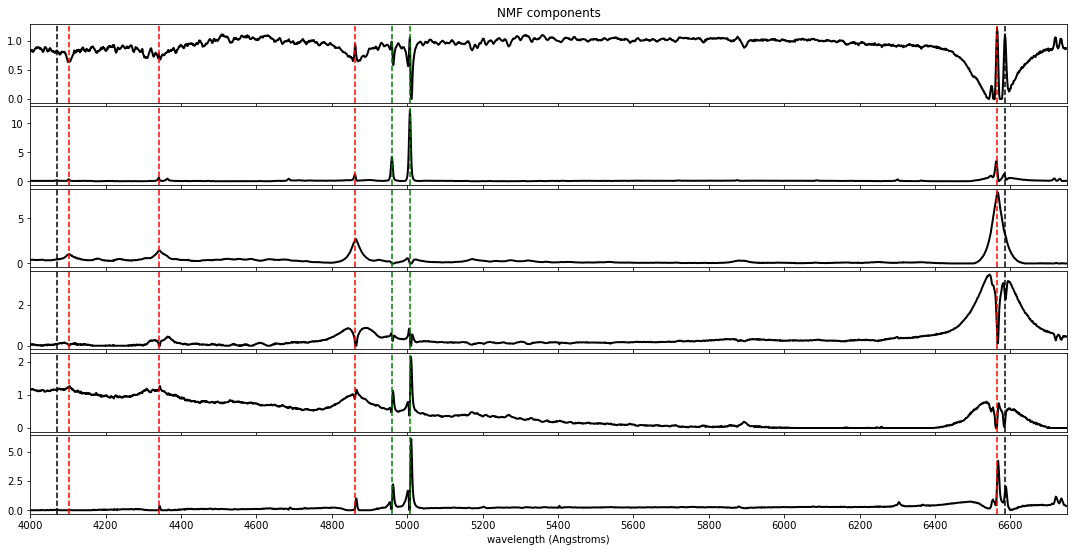

In [44]:
fig = plt.figure(figsize=(16, 8))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

title = 'NMF components'

for j in range(nmf_ncomp):
    
    # plot the components
    ax = fig.add_subplot(nmf_ncomp, 1, j+1)
    #ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.xaxis.set_major_locator(plt.MultipleLocator(200))
    if j < nmf_ncomp - 1:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_xlabel('wavelength (Angstroms)')
    ax.plot(wave[0], nmf_evecs[j], '-k', lw=2)
    ymin, ymax = ax.get_ylim()
    ax.plot([4072.3,4072.3],[ymin,ymax],'--k') #S II
    ax.plot([4102.89,4102.89],[ymin,ymax],'--r') #H ∆
    ax.plot([4341.68,4341.68],[ymin,ymax],'--r') #H gamma
    ax.plot([4862.68,4862.68],[ymin,ymax],'--r') #H ß
    ax.plot([4960.295,4960.295],[ymin,ymax],'--g') #O III
    ax.plot([5008.240,5008.240],[ymin,ymax],'--g') #O III
    ax.plot([6564.61,6564.61],[ymin,ymax],'--r') #H alpha
    ax.plot([6585.27,6585.27],[ymin,ymax],'--k') #N II
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(4000,6750)
plt.suptitle(title)    
plt.show()

### Plot histogram of eigenvalues

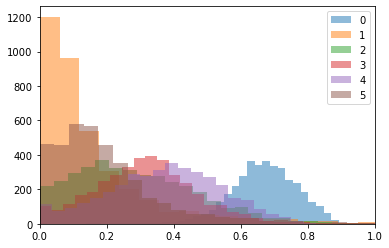

In [20]:
for i,n in enumerate(nmf_evals[0]):
    _ = plt.hist(nmf_evals[:,i],bins='scott',alpha=0.5,label='{}'.format(i))
plt.xlim(0,1)
plt.legend(loc=1)
plt.show()

In [21]:
nspec=10
# Pull out a random spectrum
m = np.random.randint(0,nspec-1)
spec_m = spectra_norm[m]  #Could similarly do X[m]
evals_m = nmf_evals[m]
print(evals_m)

[0.7085475  0.         0.36200792 0.03326571 0.45824698 0.19360447]


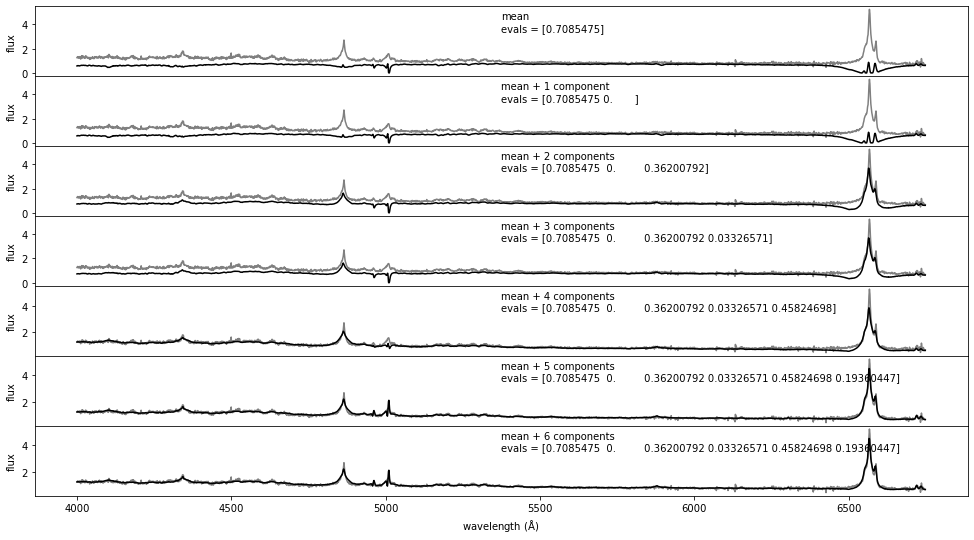

In [22]:
# Plot the sequence of reconstructions for said spectrum
fig = plt.figure(figsize=(16, 8))
fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)

for i, n in enumerate(np.arange(nmf_ncomp+1)):
    #ax = fig.add_subplot(511 + i)
    ax = fig.add_subplot(nmf_ncomp+1, 1, i+1)
    ax.plot(wave[0], spec_m, '-', c='gray')
    ymin, ymax = ax.get_ylim()
    ax.plot(wave[0], np.dot(evals_m[:n+1], nmf_evecs[:n+1]), '-k')
    
    if i < nmf_ncomp:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    #ax.set_ylim(-2, 21)
    ax.set_ylabel('flux')

    if n == 0:
        text = "mean\n"
        text += "evals = %s" % evals_m[:n+1]
        
    elif n == 1:
        text = "mean + 1 component\n"
        text += "evals = %s" % evals_m[:n+1]

    else:
        text = "mean + %i components\n" % n
        text += "evals = %s" % evals_m[:n+1]

    ax.text(0.5, 0.93, text, ha='left', va='top', transform=ax.transAxes)
    #ax.plot([1640.42,1640.42],[ymin,ymax],'--k')
    #ax.plot([1663.48,1663.48],[ymin,ymax],'--k')
    #ax.plot([1857.40,1857.40],[ymin,ymax],'--k')
    #ax.plot([1892.03,1892.03],[ymin,ymax],'--k')
    #ax.plot([1908.73,1908.73],[ymin,ymax],'--k')
    #ax.plot([2798.75,2798.75],[ymin,ymax],'--k')
    #ax.set_xlim(1600,3000)

fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
plt.show()

---

Now load in our spectra and reconstruct

In [23]:
dat = pd.read_csv("../data/ParentSample_DR7props.csv")
dat.head()

A_morph           SDSS_NAME          RA        DEC  REDSHIFT  PLATE  FIBER  \
0       D  093509.48+481910.2  143.789520  48.319504    0.2238    834    361   
1       E  152925.98+021646.6  232.358261   2.279618    0.2634   2954    379   
2       E  144414.66+063306.7  221.061111   6.551877    0.2080   1829    464   
3       E  140808.19+430316.5  212.034164  43.054600    0.2581   1467     48   
4       E  172711.80+632242.1  261.799194  63.378372    0.2174    352    639   

     MJD  TARGET_FLAG_TARGET  NSPECOBS  ...    f_c   logL     i_2   I_2a  \
0  52316                7691         1  ...  1.000  22.92  17.026 -22.73   
1  54561                   3         1  ...  1.000  22.47  17.490 -22.61   
2  53494           135273475         1  ...  1.000  22.47  16.552 -23.04   
3  53115                7171         1  ...  1.000  22.99  16.922 -23.14   
4  51789                7168         2  ...  1.000  22.97  16.730 -22.95   

      R         LD_cm       Lobs   L_1.4GHz  SFR (Msun/yr)  Separation  
0  1.07  3.434469e+27  22.949804  23.453667     167.694491         0.0  
1  0.41  4.120027e+27  22.510854  23.024252      62.388456         0.0  
2  0.29  3.160119e+27  22.505157  23.005020      59.685944         0.0  
3  0.85  4.030828e+27  23.028500  23.540693     204.901363         0.0  
4  0.99  3.313937e+27  23.002030  23.504149     188.365559         0.0  

[5 rows x 163 columns]

In [50]:
dat.shape

(178, 163)

In [24]:
sdss_name = dat["SDSS_NAME"].values
z         = dat["REDSHIFT"].values
plate     = dat["PLATE"].values
mjd       = dat["MJD"].values
fiber     = dat["FIBER"].values
A_morph = {
    "RL": isNaN(dat["A_morph"].values),
    "U": dat["A_morph"].values=="U",
    "D": dat["A_morph"].values=="D",
    "E": dat["A_morph"].values=="E",
    "M": dat["A_morph"].values=="M",
    "SR":dat["A_morph"].values=="SR",
    "ND":dat["A_morph"].values=="ND"
}

In [49]:
#Will want to save homogeneous arrays of each QSO's wavelength, flux, and inverse variance
names   = []
rqqs = []
wave    = []
ivar    = []
found   = [] #save dataframe indices which have spectra
N = 0

for sdss_name, red, pl, mj, fib in zip(sdss_name, z, plate, mjd, fiber):
    try:
        hdul_spec = fits.open("../data/spectra/kimballsample_full/%04d/spec-%04d-%05d-%04d.fits" % (pl,pl,mj,fib))
    except FileNotFoundError:
        print("../data/spectra/kimballsample_full/%04d/spec-%04d-%05d-%04d.fits NOT FOUND" % (pl,pl,mj,fib))
        continue
        
        
    #Load in data from each FITS file
    sdss_flux   = hdul_spec[1].data["flux"]
    sdss_loglam = hdul_spec[1].data["loglam"]
    sdss_wave   = 10.**(sdss_loglam) / (1+red)  #x-axis: wavelength
    sdss_ivar   = hdul_spec[1].data["ivar"]
    
    #Want the same wavelength range for each array
    wavemask   = ((sdss_wave>=4000) & (sdss_wave<=6750)) #Halpha wavelength range
    sdss_flux  = sdss_flux[wavemask]
    sdss_flux /= np.median(sdss_flux) #normalize spectrum
    sdss_ivar  = sdss_ivar[wavemask]
    sdss_wave  = sdss_wave[wavemask]
    hdul_spec.close()

    if len(sdss_flux) >= 2272:
        names.append(sdss_name[:2272])
        rqqs.append(sdss_flux[:2272])
        wave.append(sdss_wave[:2272])
        ivar.append(sdss_ivar[:2272])
        found.append(N)
    else:
        print(len(sdss_flux), sdss_name)

    N+=1
    if N%1000==0: print(N)  
    
rqqs = np.array(rqqs)
wave    = np.array(wave)
ivar    = np.array(ivar)
found   = np.array(found)

In [26]:
rqqs[rqqs<0] = 0

In [27]:
eigvals_rqqs = nmf.transform(rqqs)

In [28]:
eigvals_rqqs

array([[0.37810975, 1.6702838 , 0.11105939, 0.45422542, 0.6094362 ,
        0.6493425 ],
       [0.6035484 , 0.10959705, 0.3894584 , 0.27472904, 0.5434951 ,
        0.18206449],
       [0.4482258 , 0.23830949, 0.4444201 , 0.55060047, 0.54575855,
        0.28493816],
       ...,
       [0.5367962 , 0.11988238, 0.15341194, 0.77762634, 0.5359609 ,
        0.06288072],
       [0.6825758 , 0.45424008, 0.00980049, 0.11911451, 0.44788152,
        0.3569512 ],
       [0.4020842 , 0.3457482 , 0.61098725, 1.2251401 , 0.38943315,
        0.10670245]], dtype=float32)

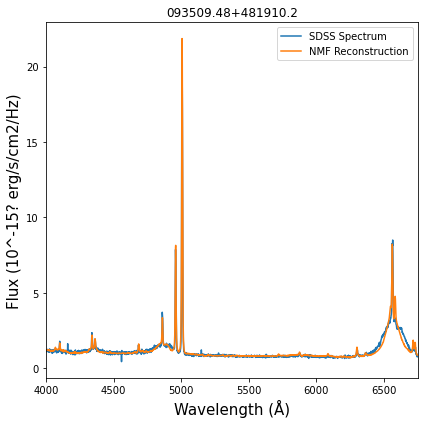

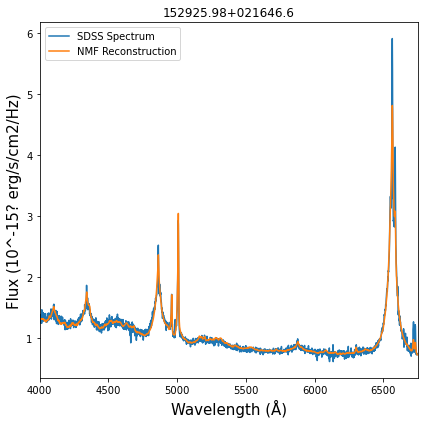

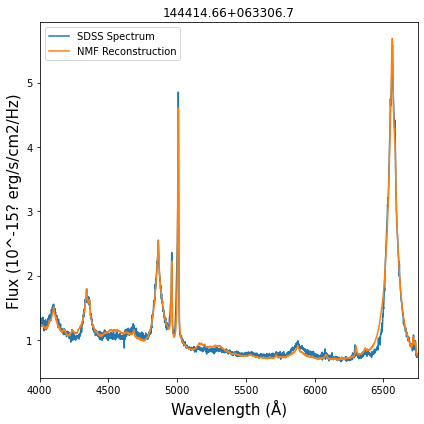

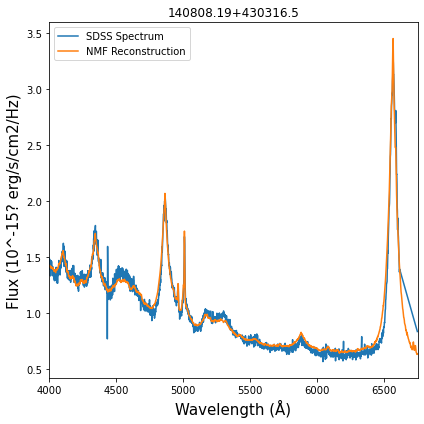

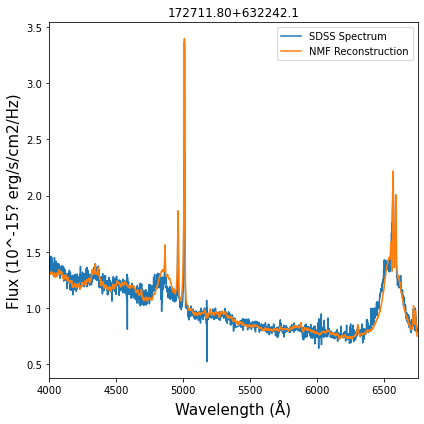

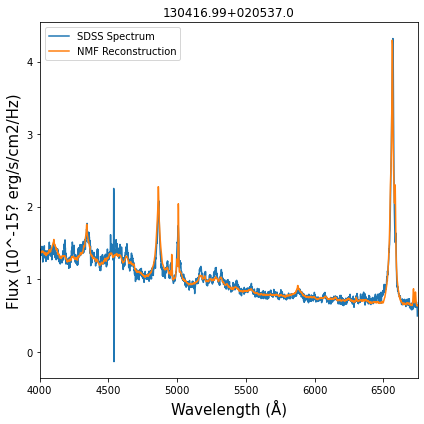

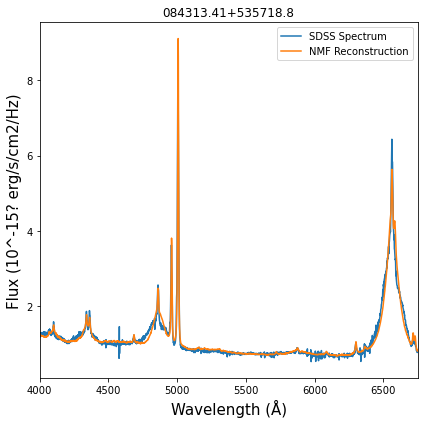

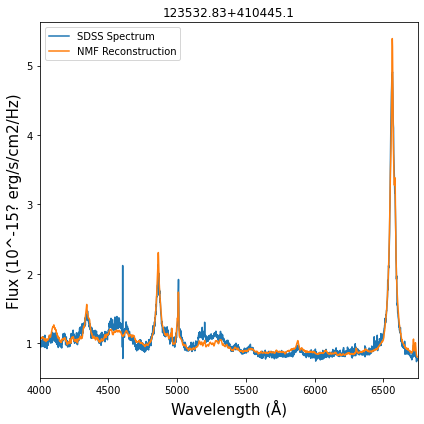

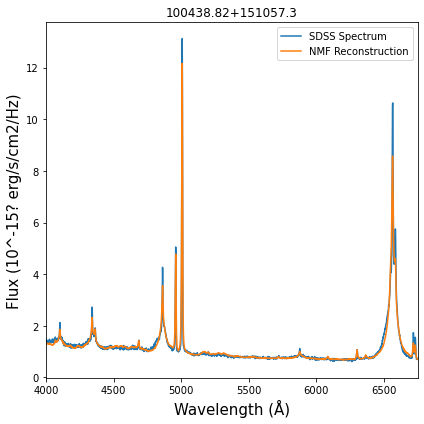

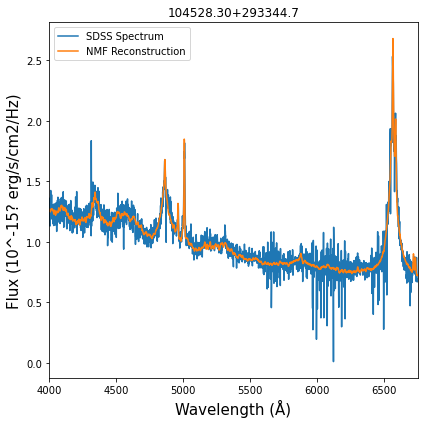

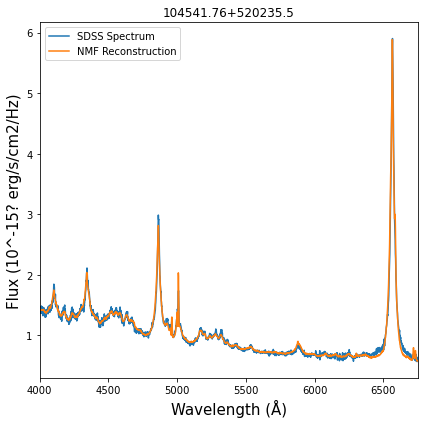

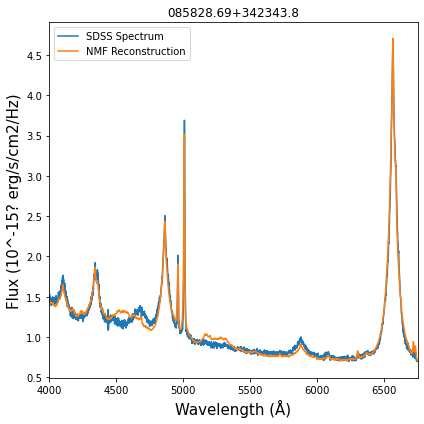

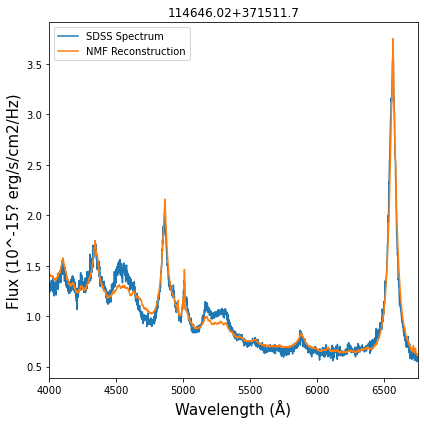

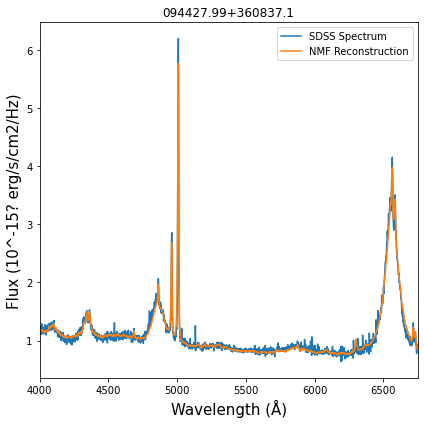

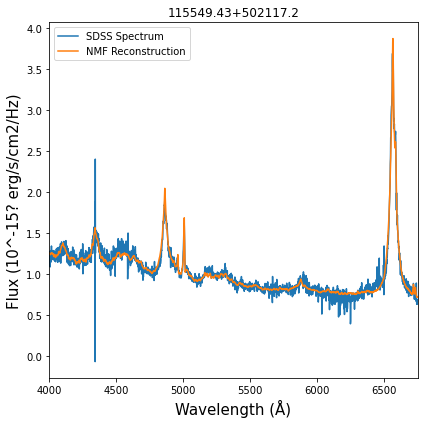

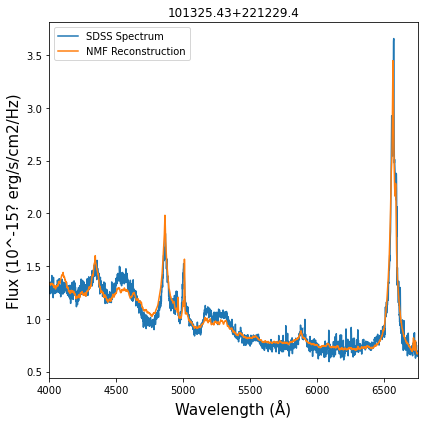

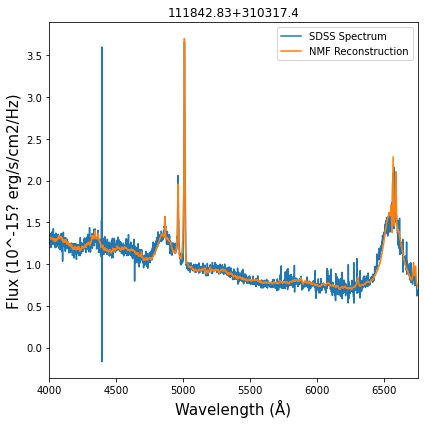

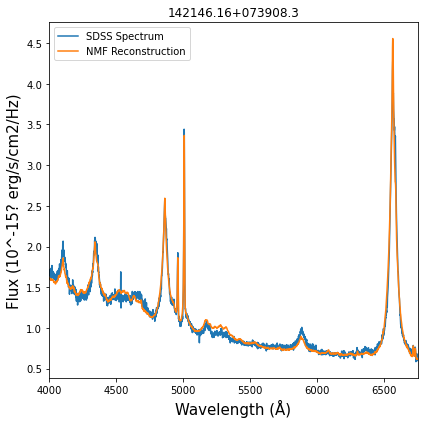

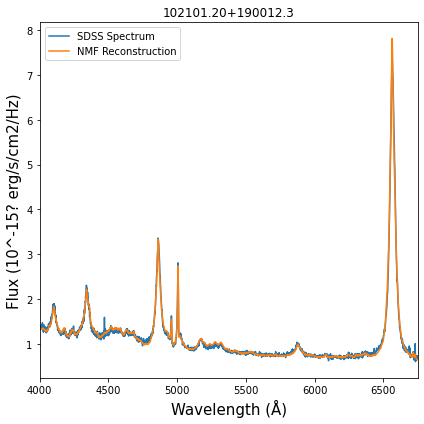

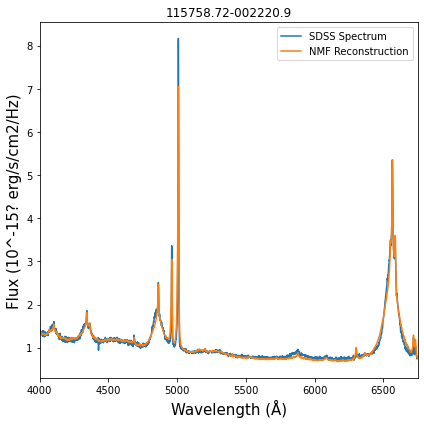

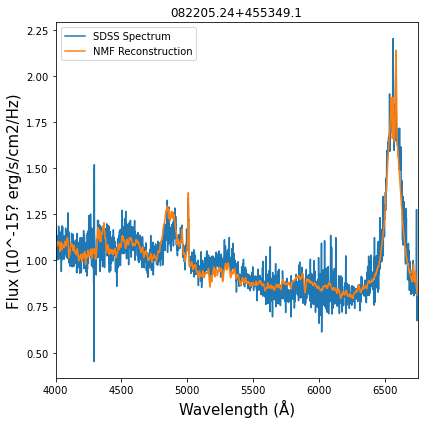

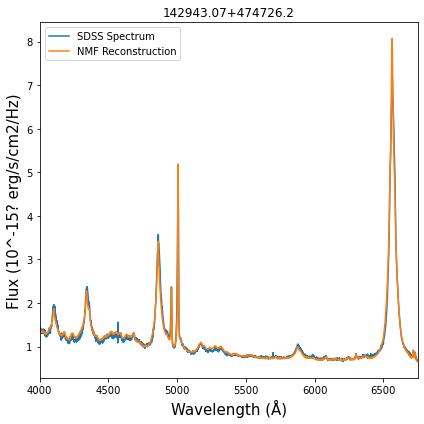

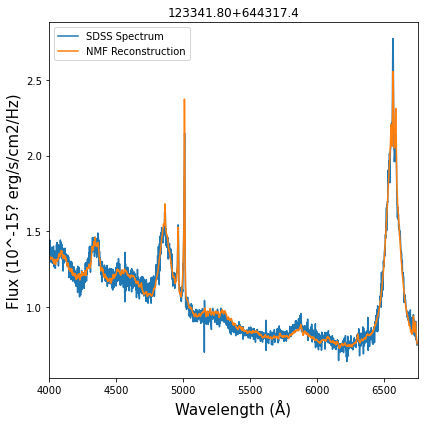

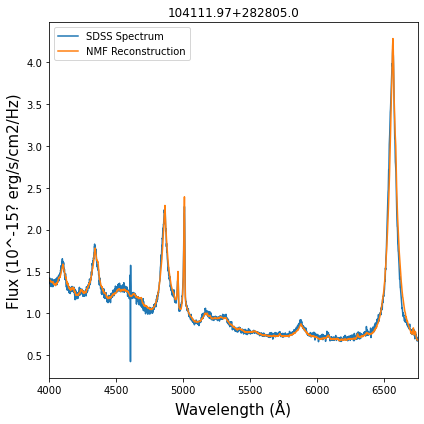

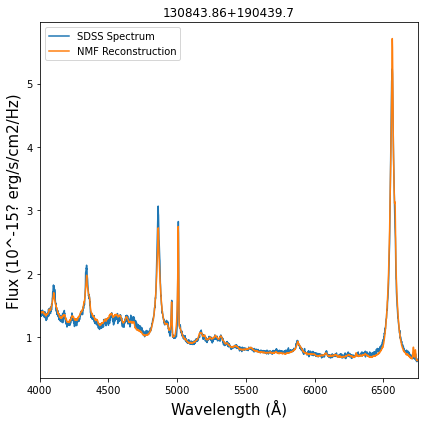

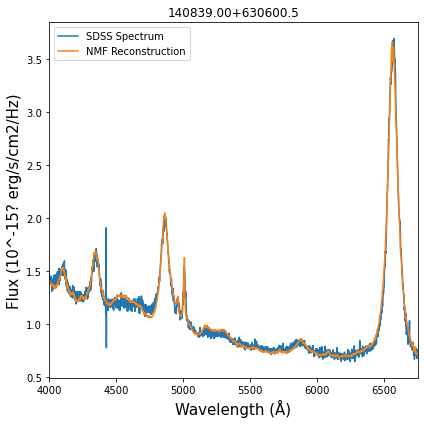

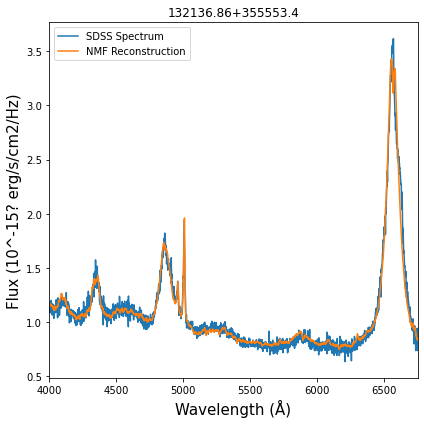

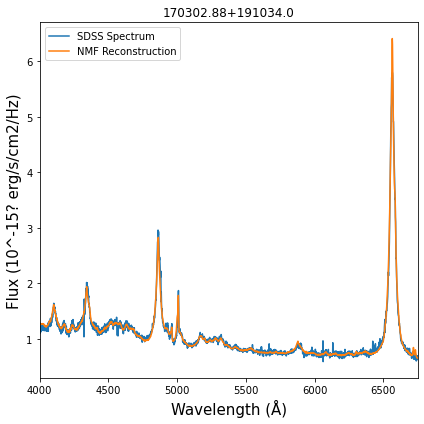

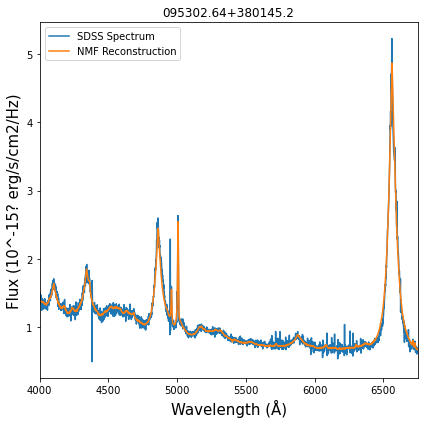

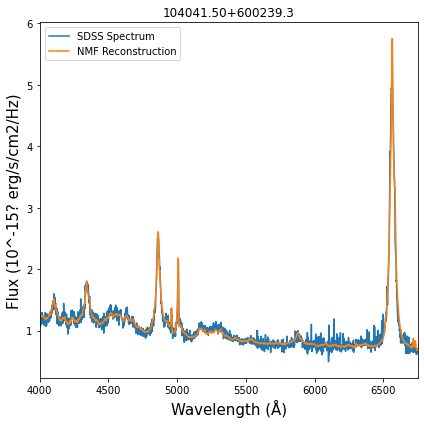

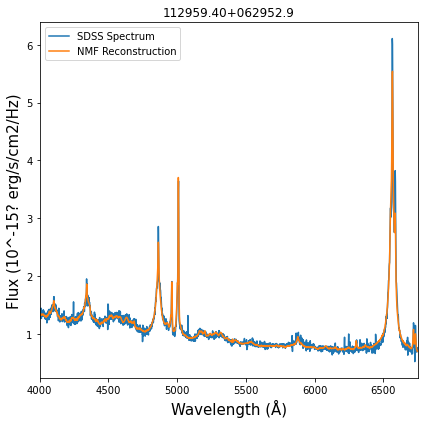

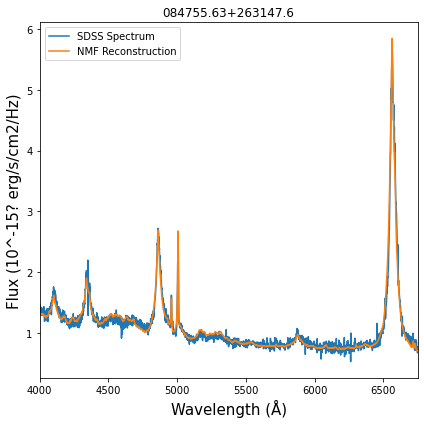

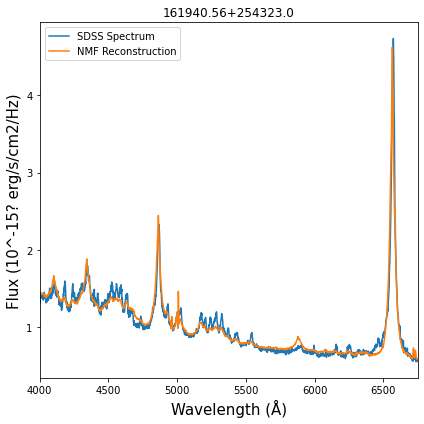

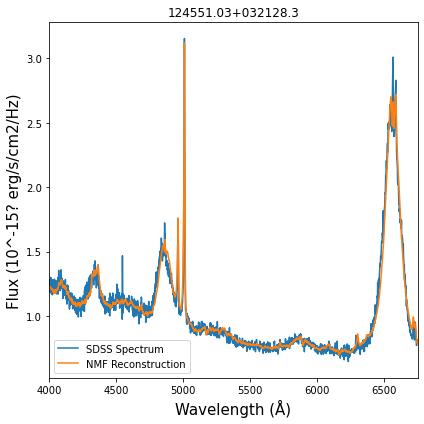

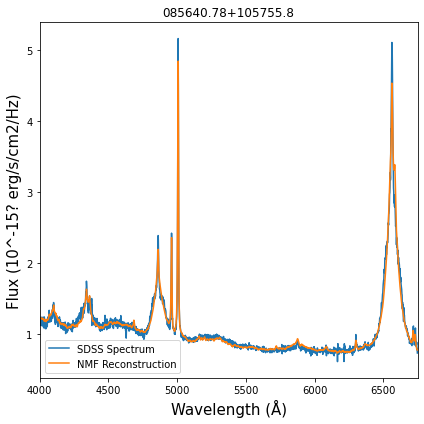

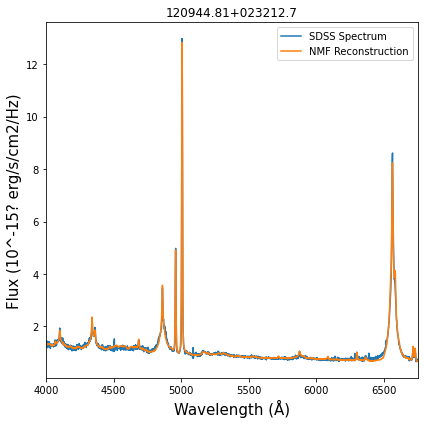

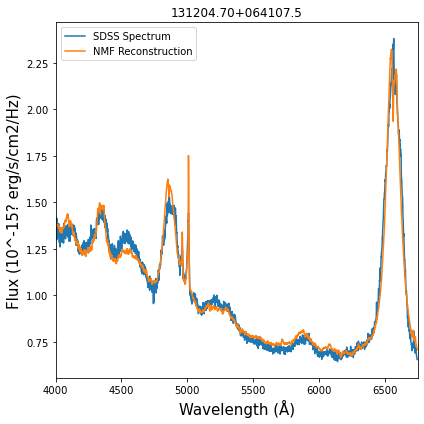

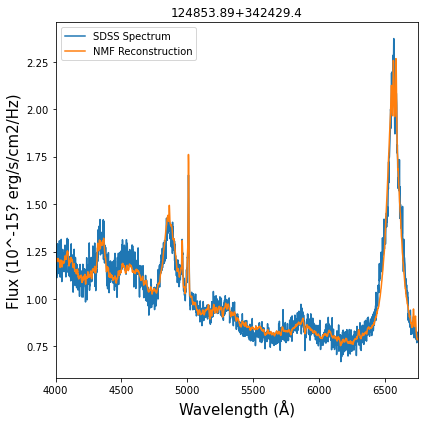

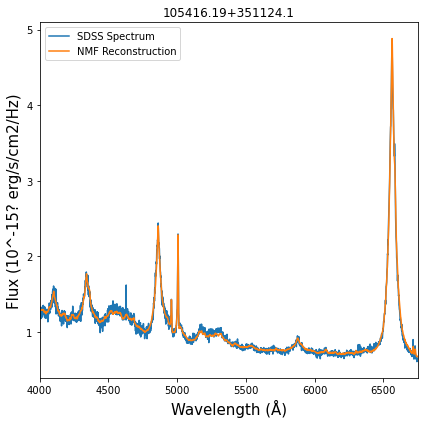

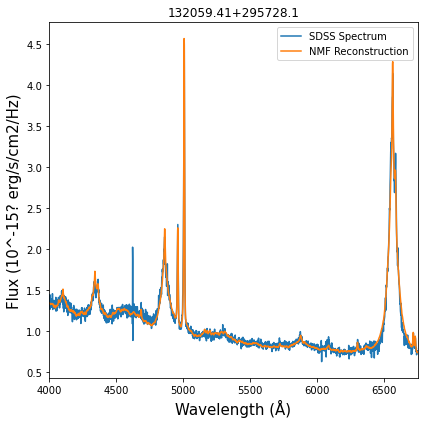

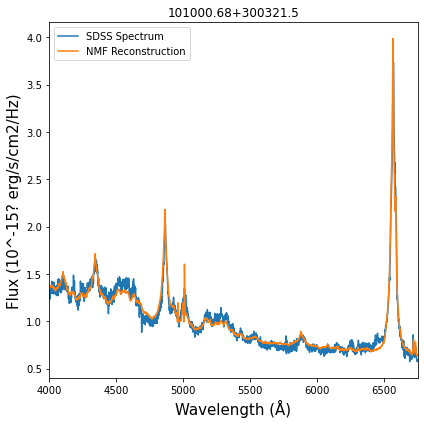

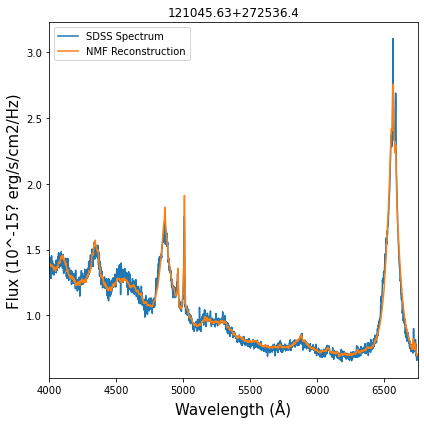

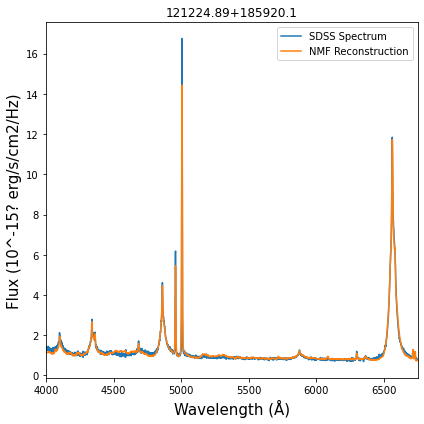

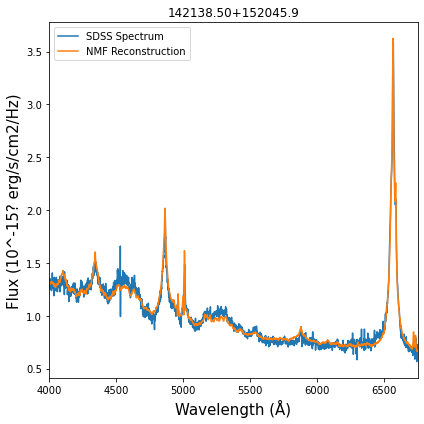

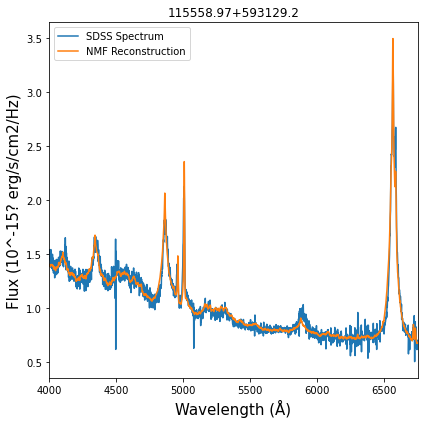

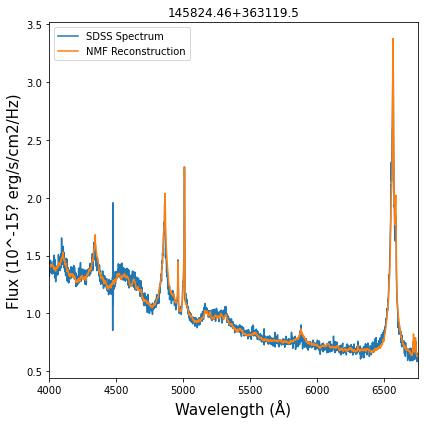

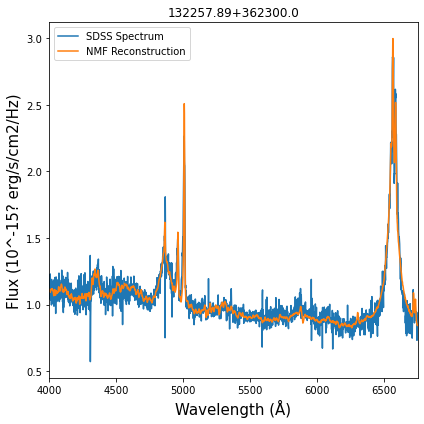

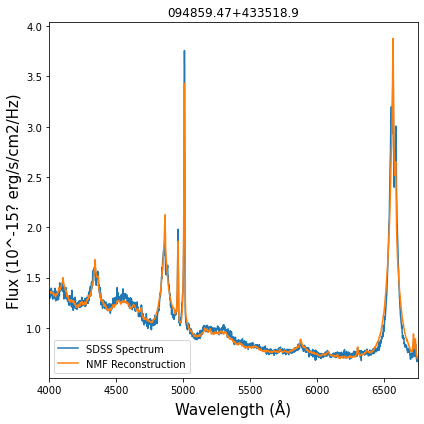

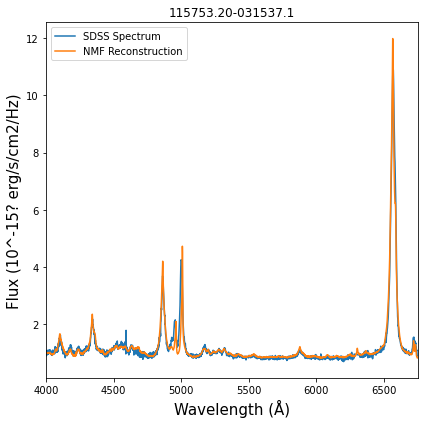

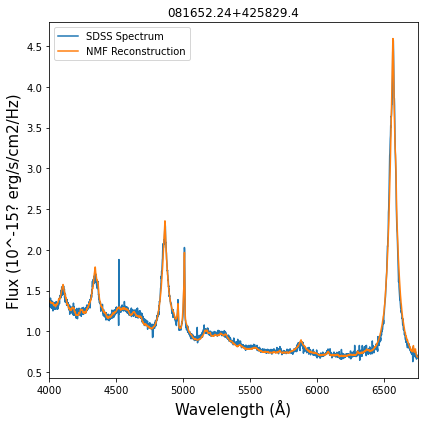

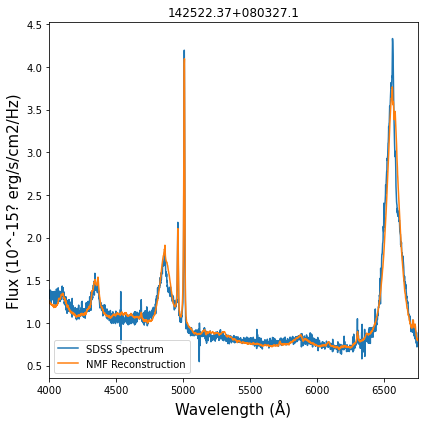

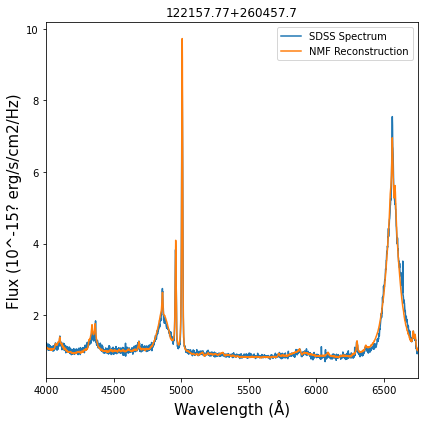

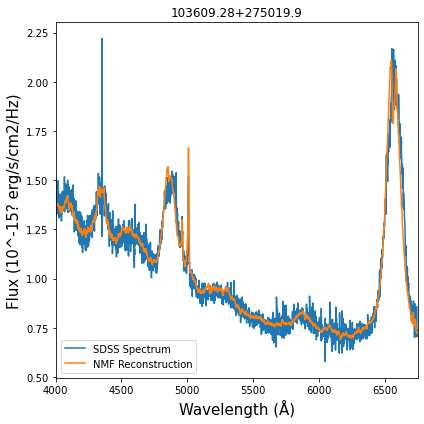

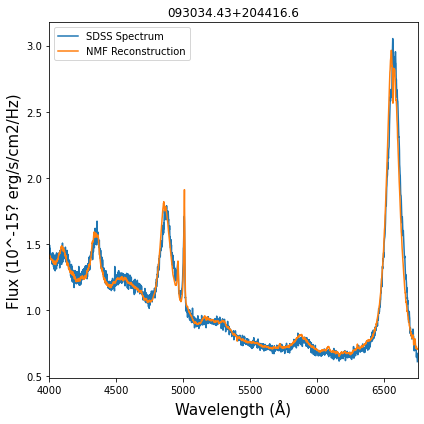

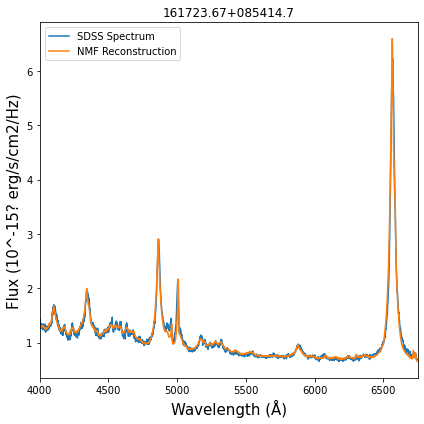

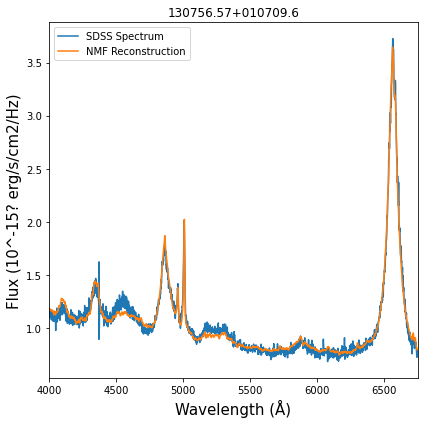

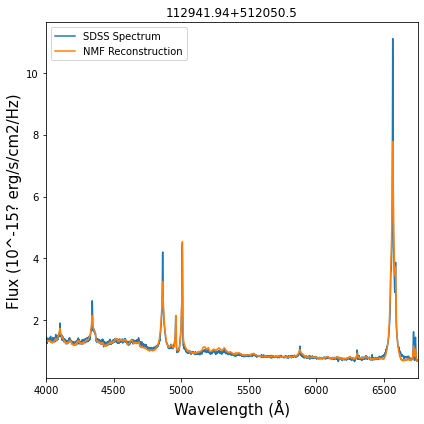

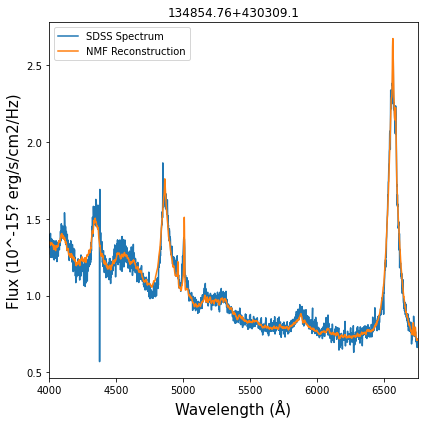

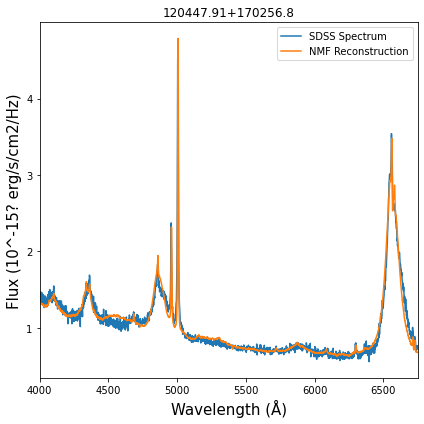

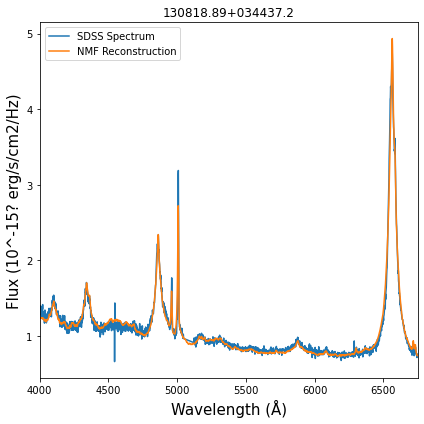

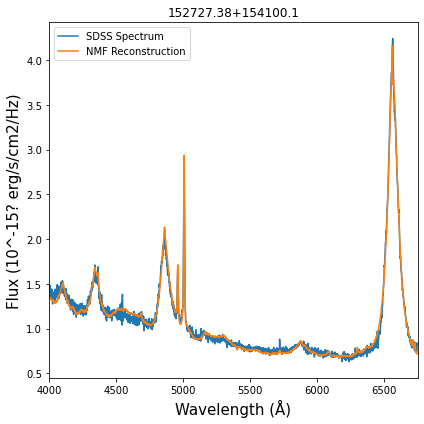

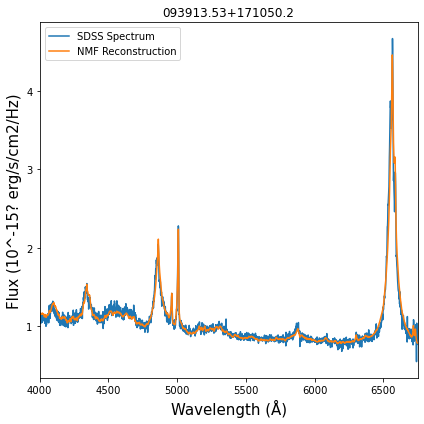

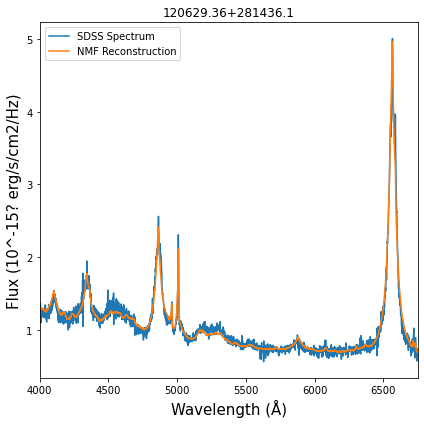

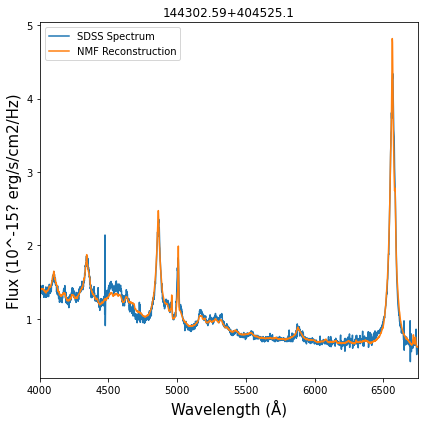

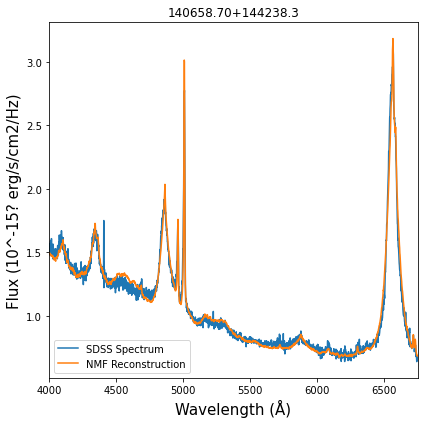

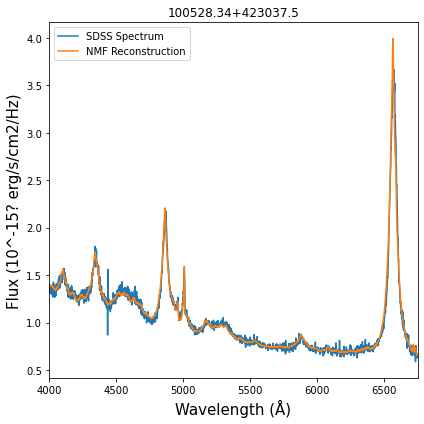

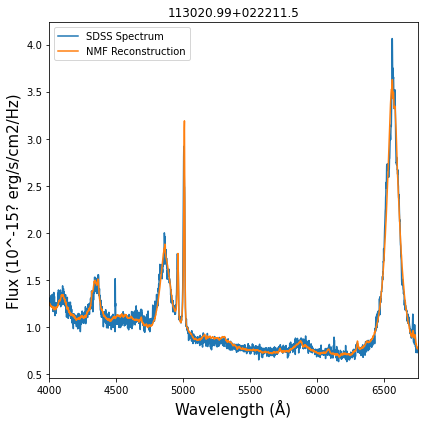

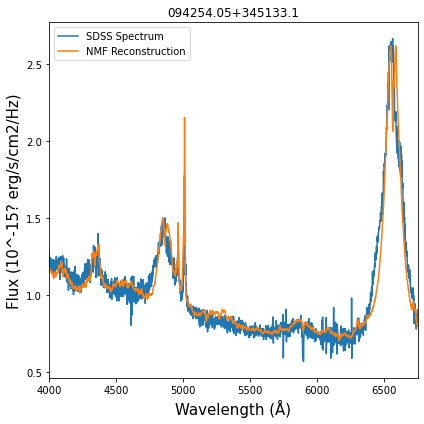

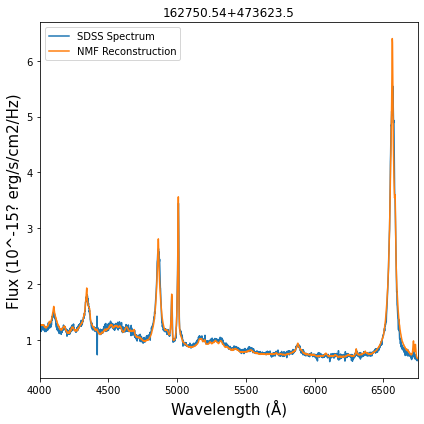

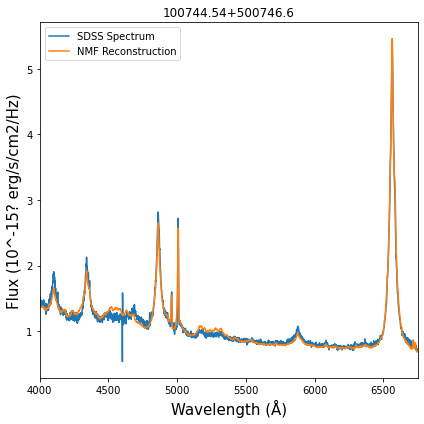

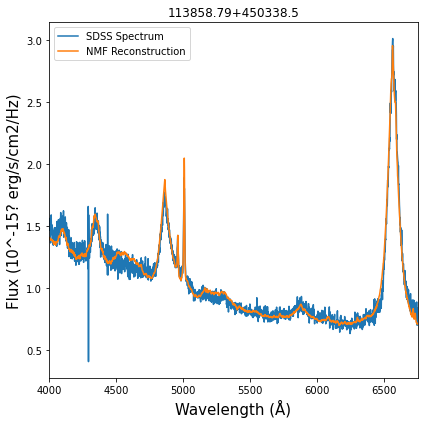

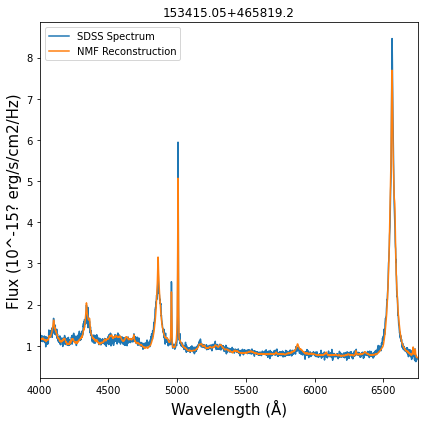

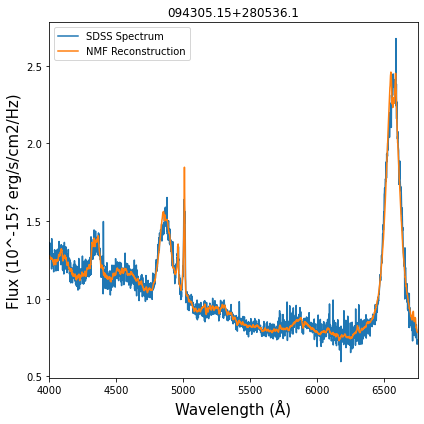

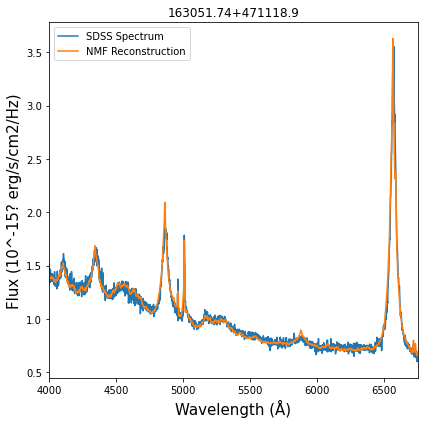

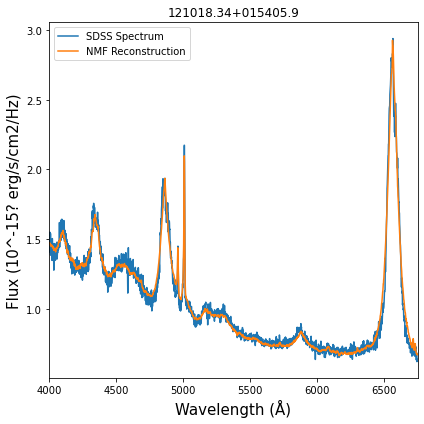

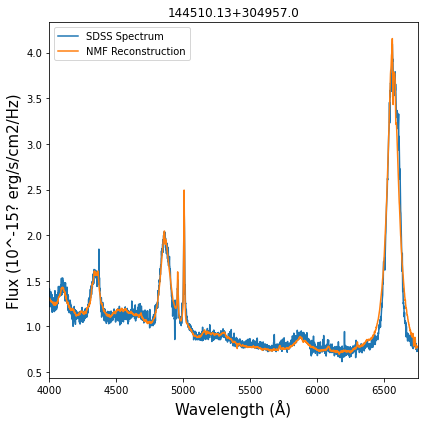

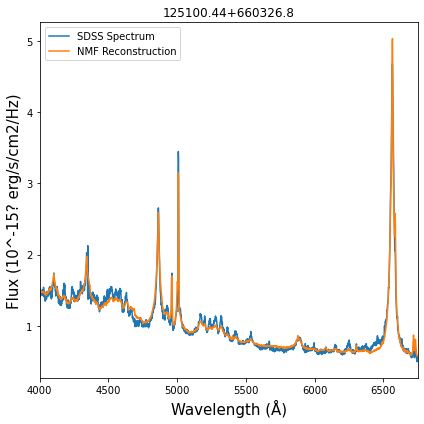

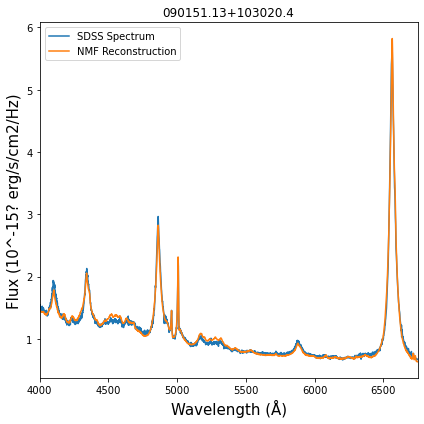

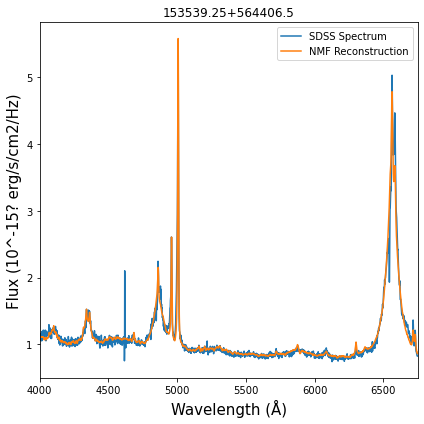

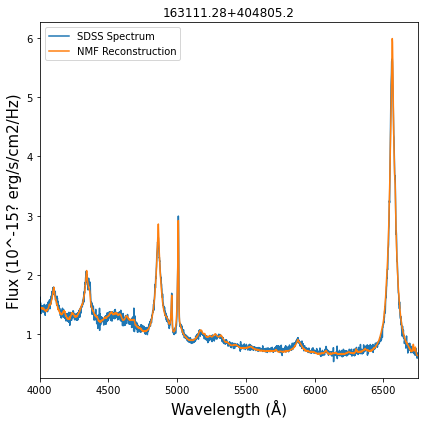

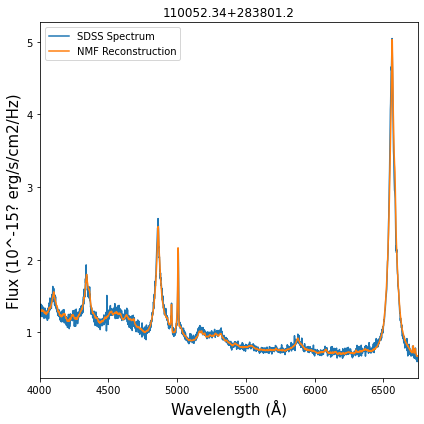

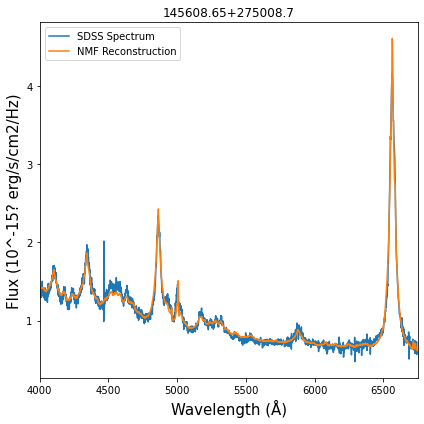

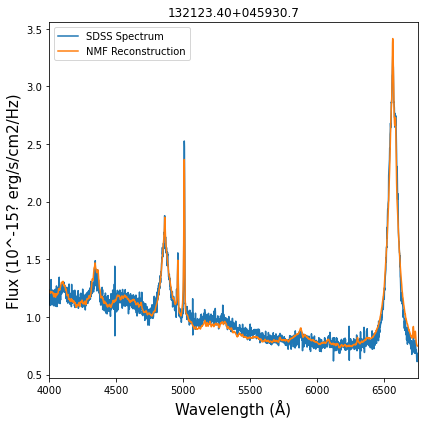

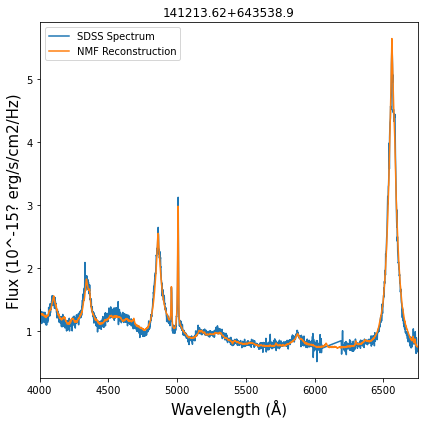

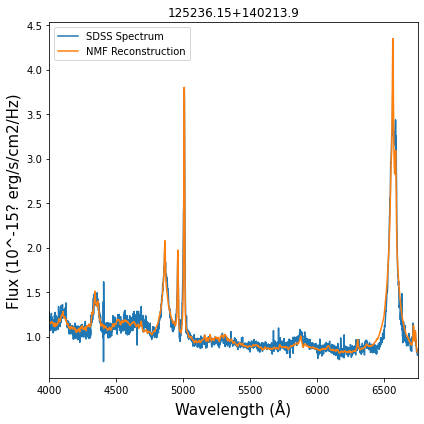

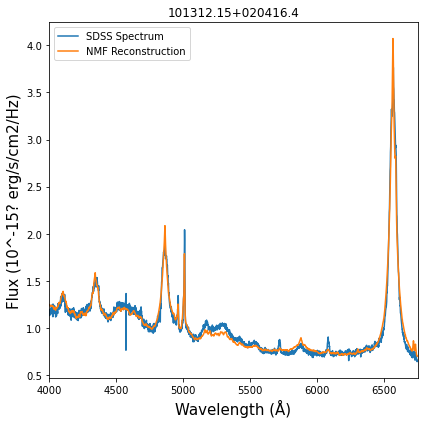

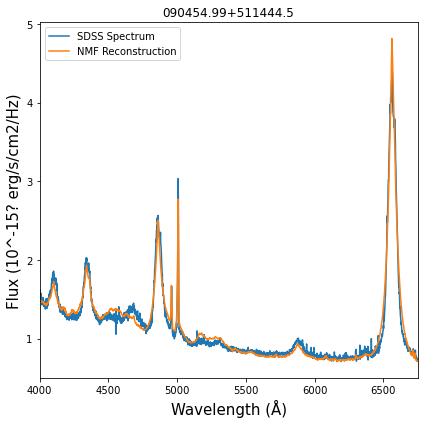

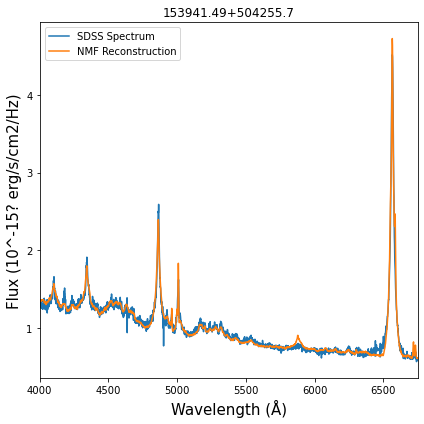

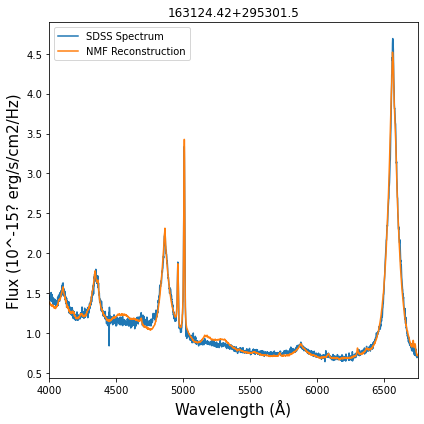

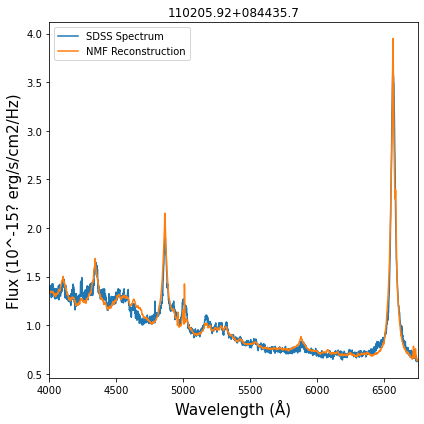

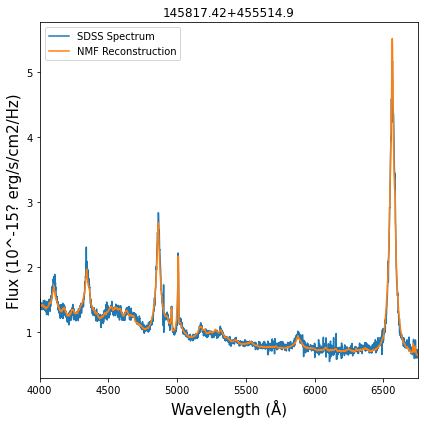

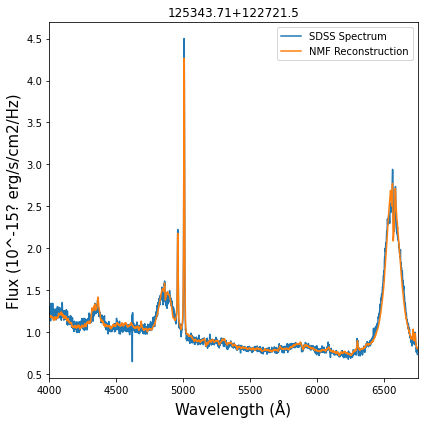

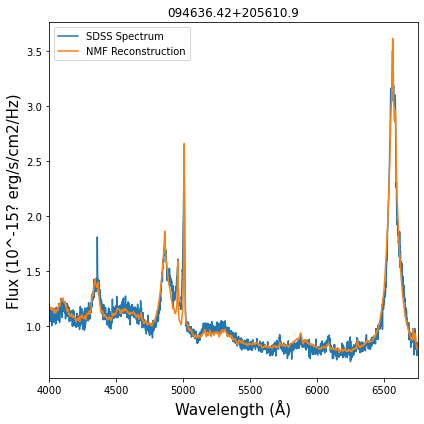

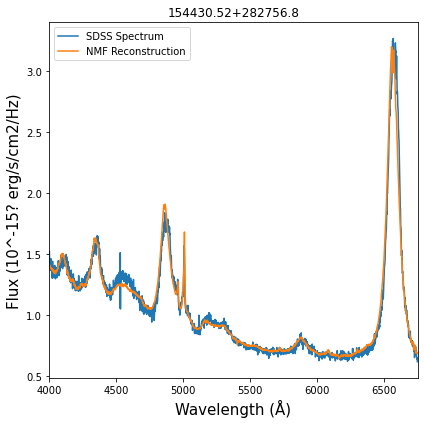

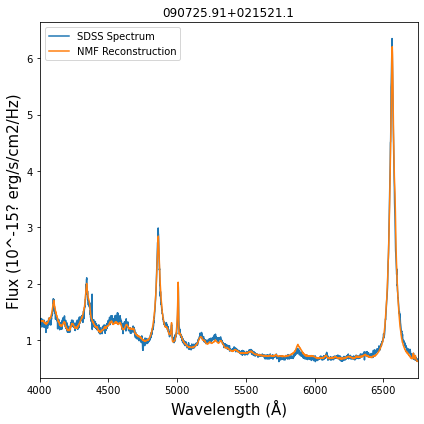

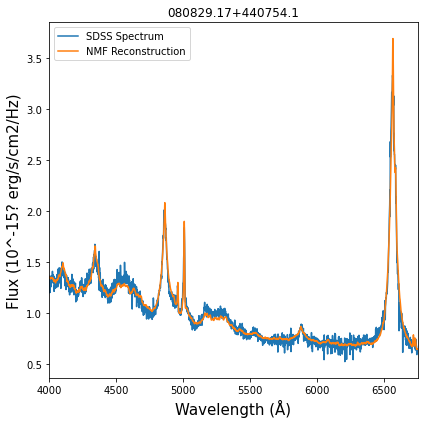

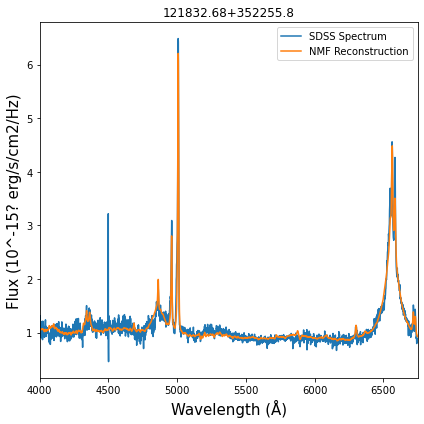

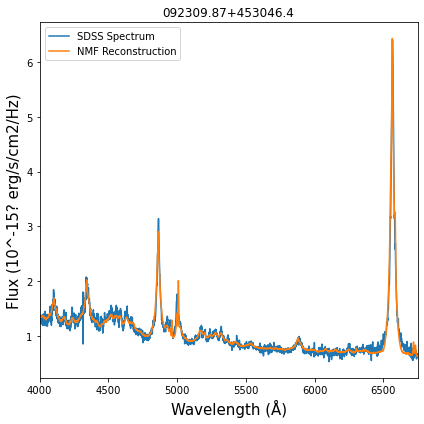

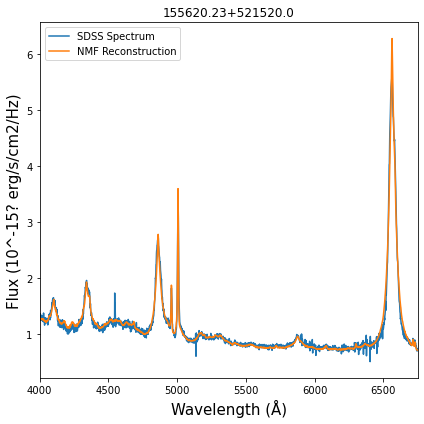

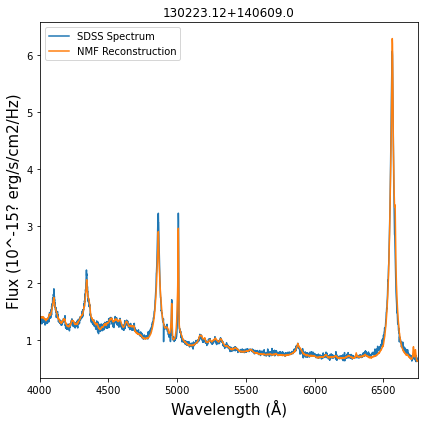

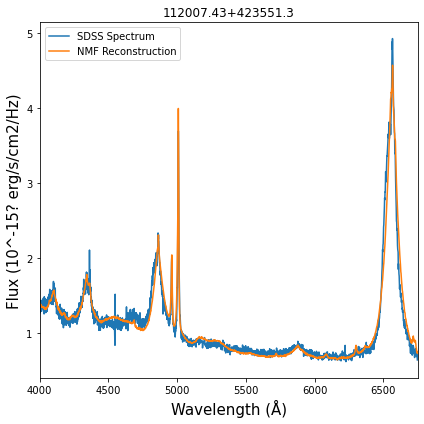

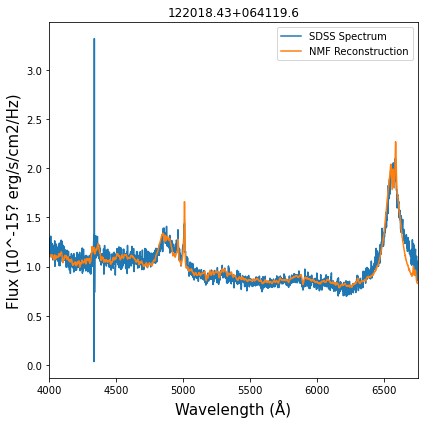

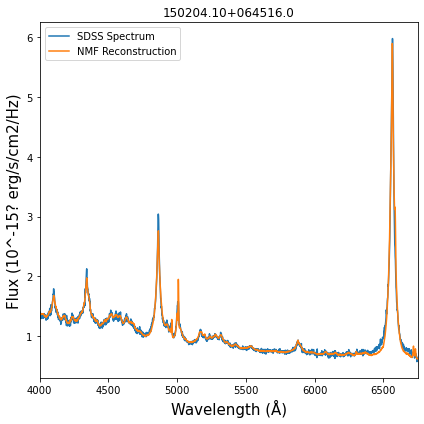

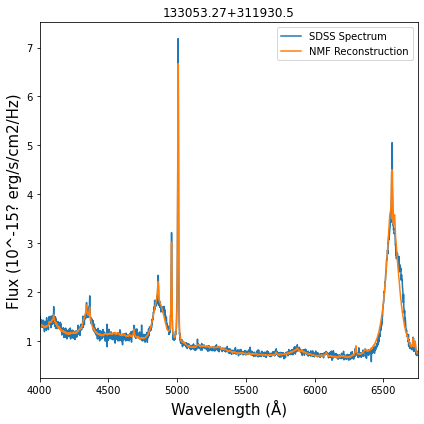

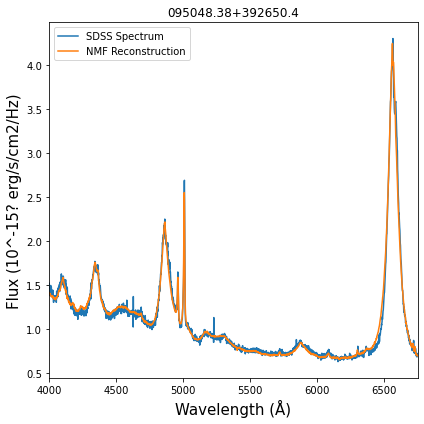

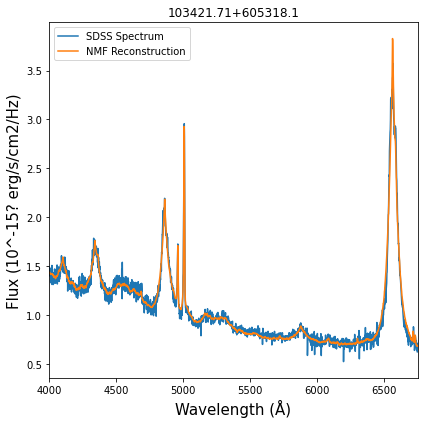

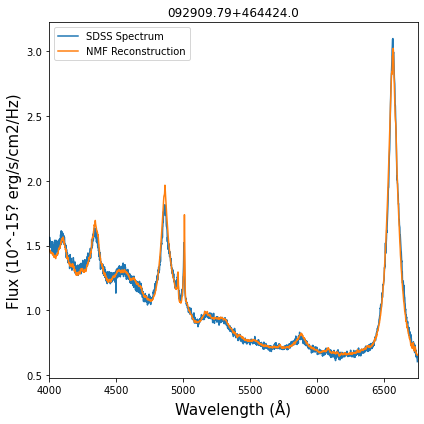

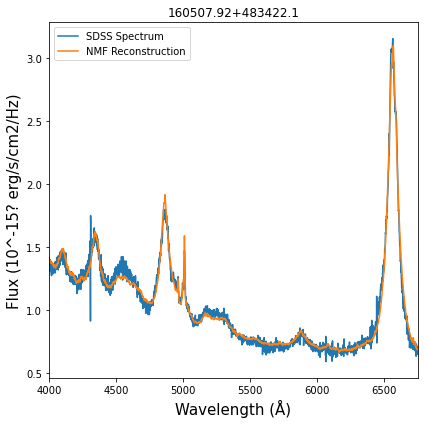

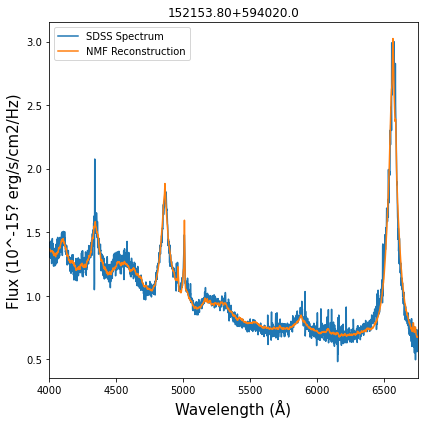

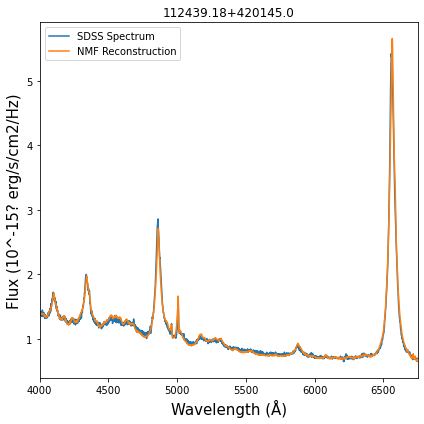

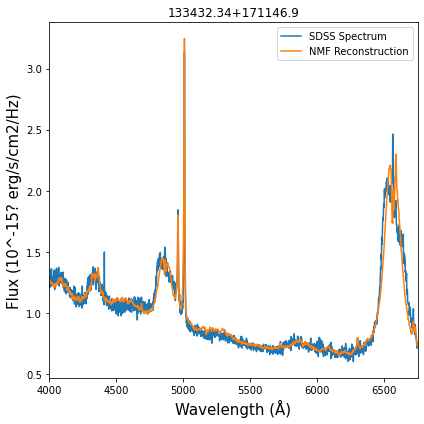

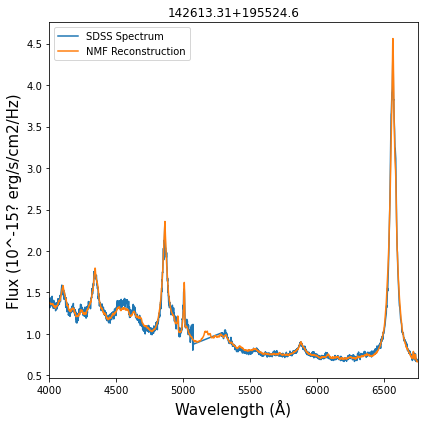

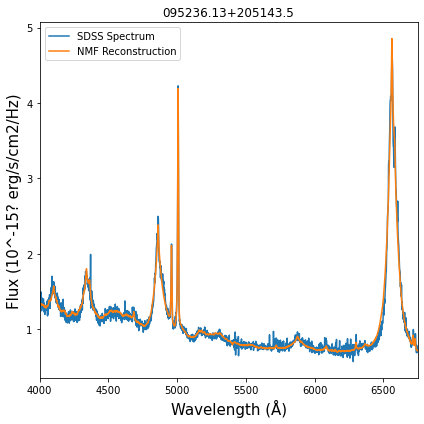

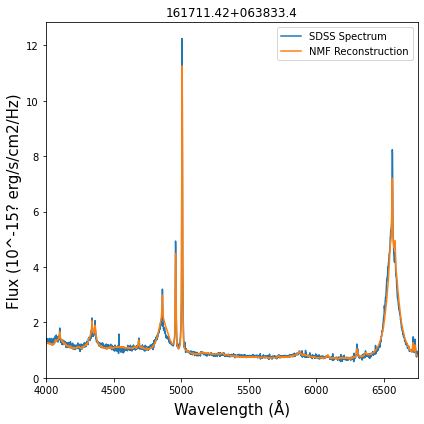

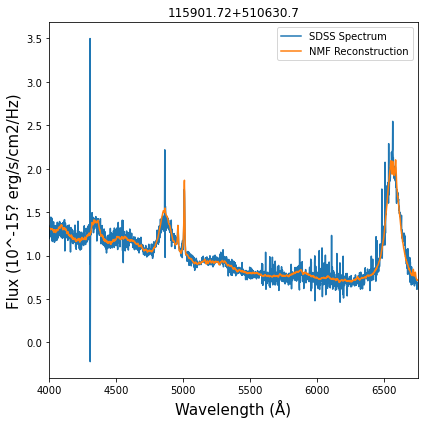

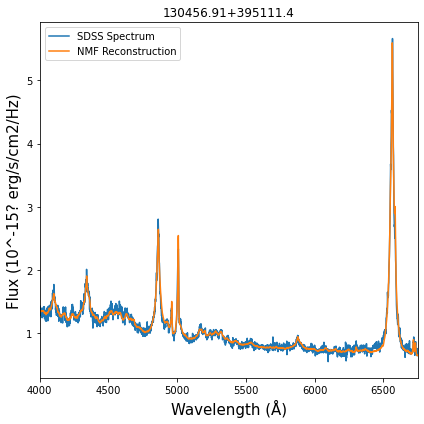

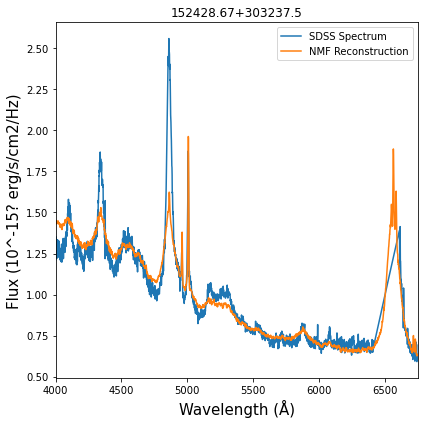

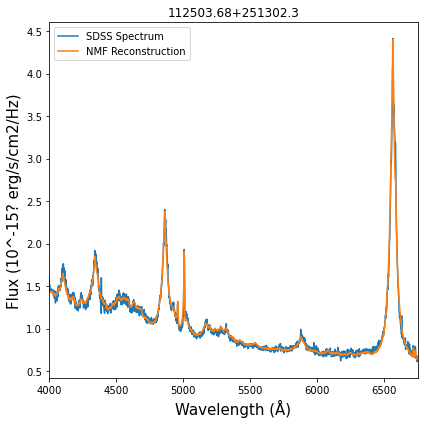

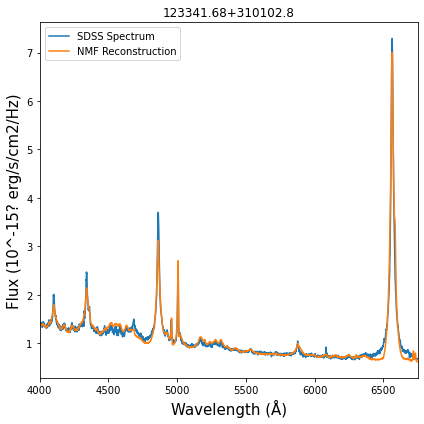

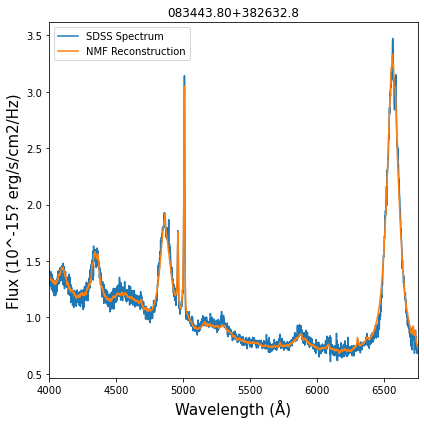

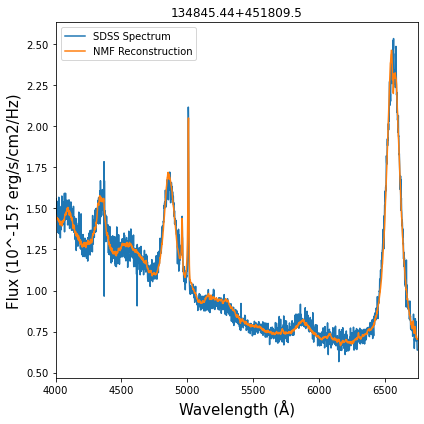

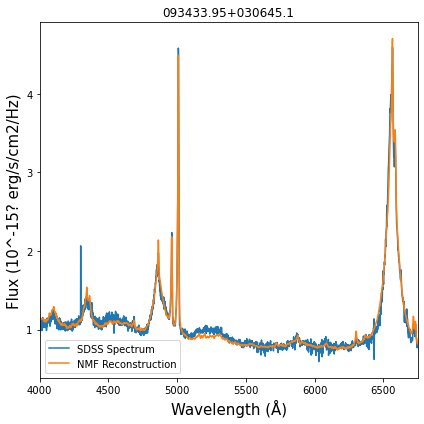

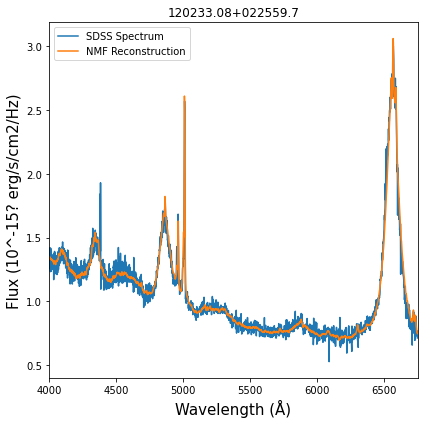

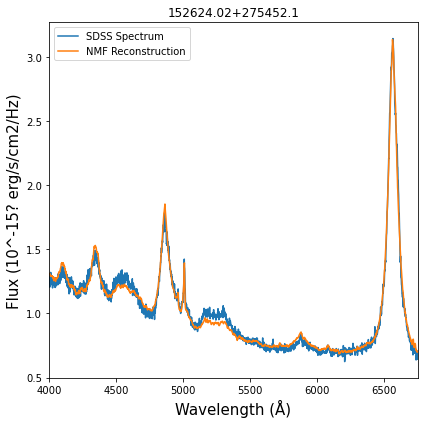

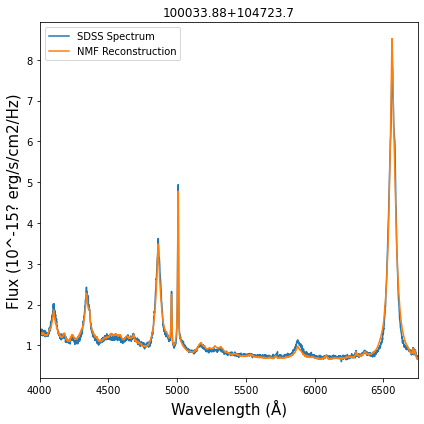

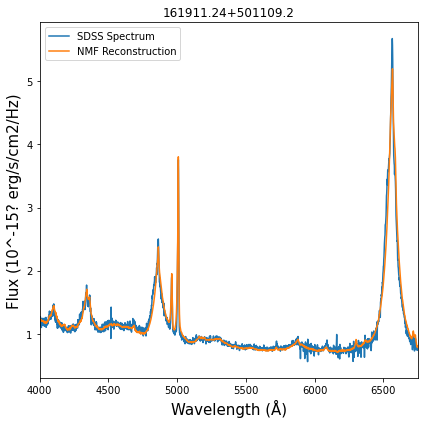

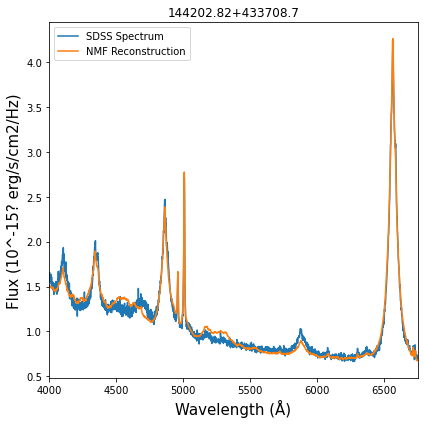

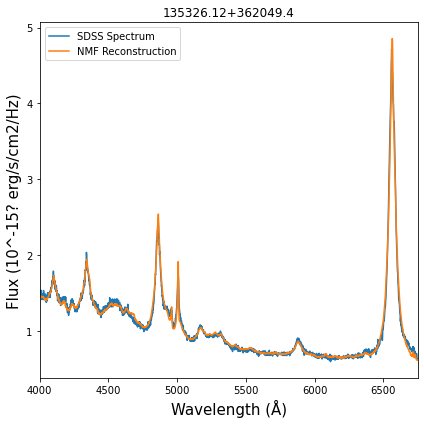

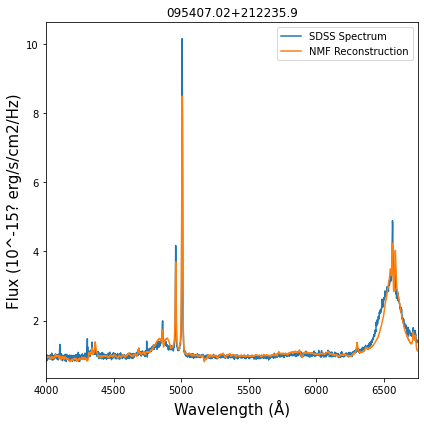

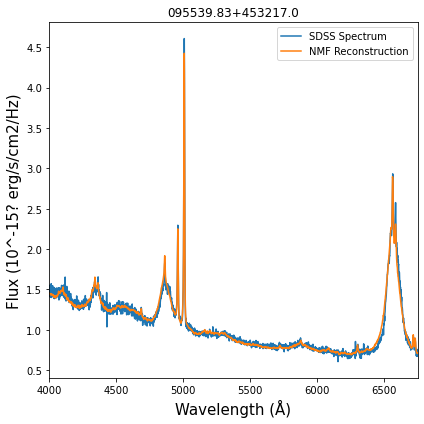

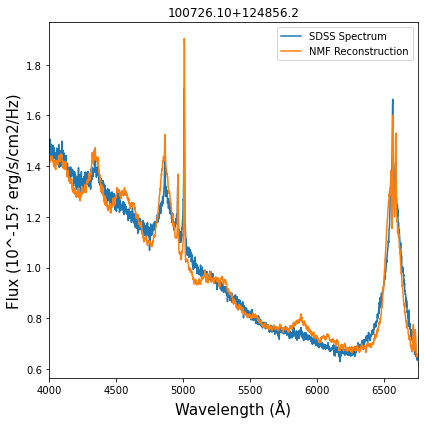

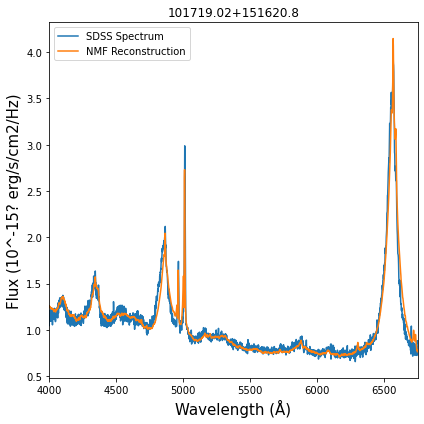

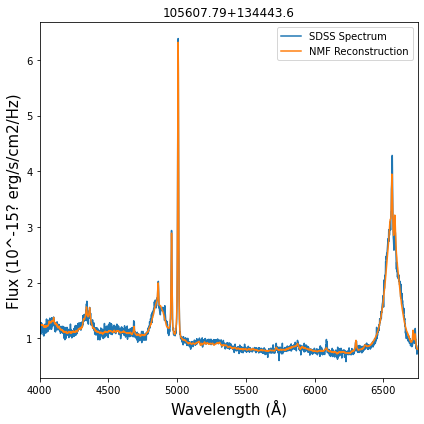

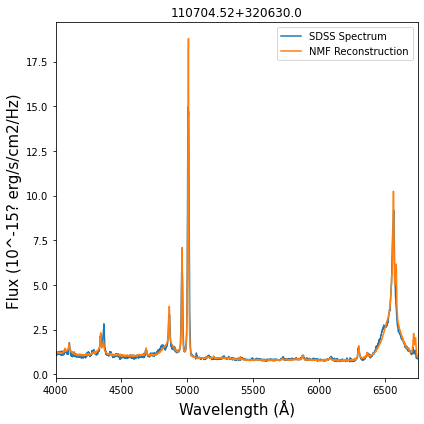

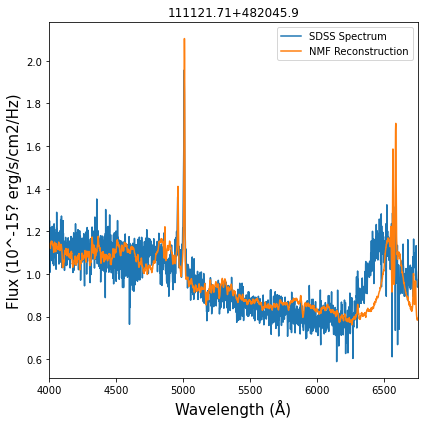

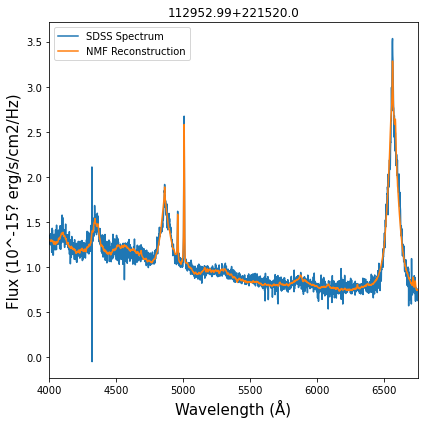

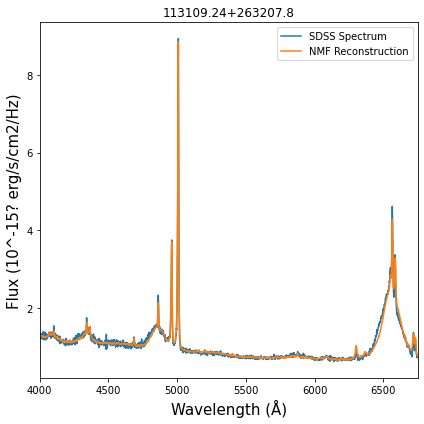

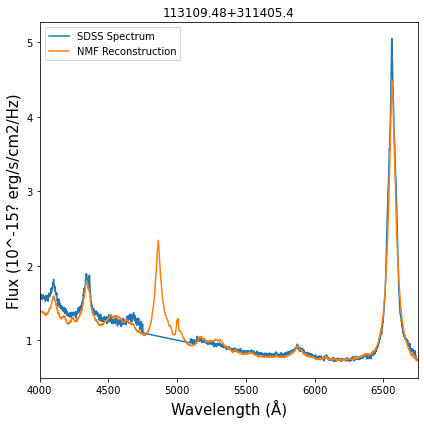

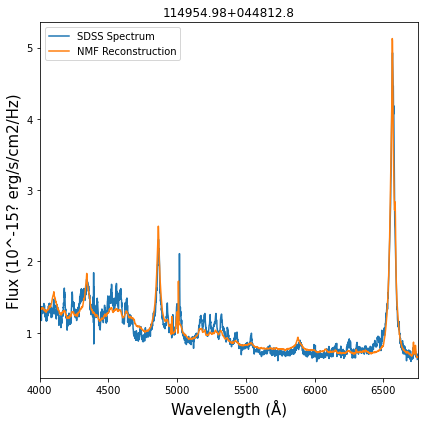

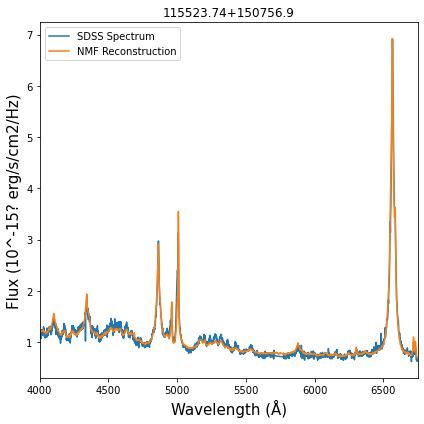

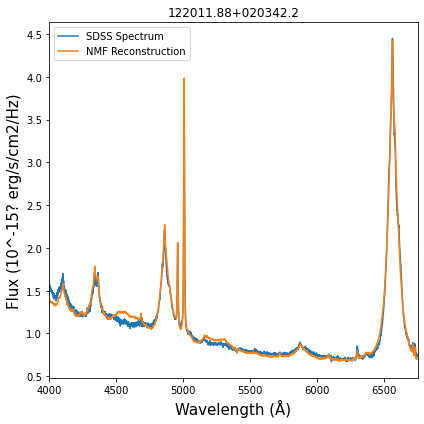

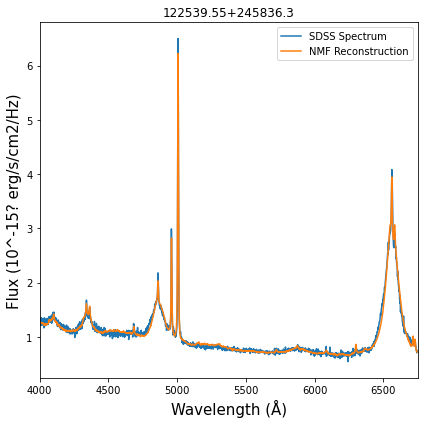

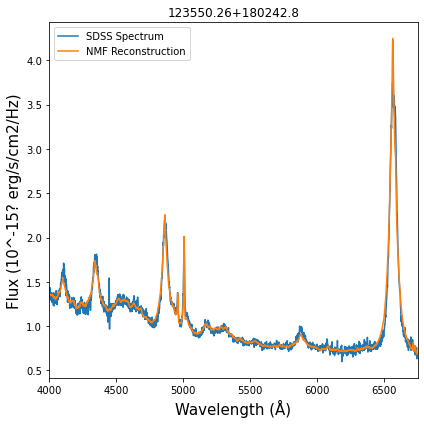

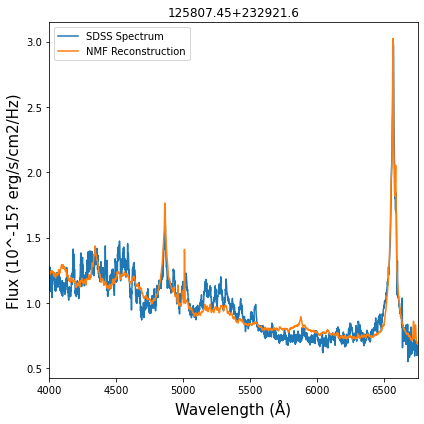

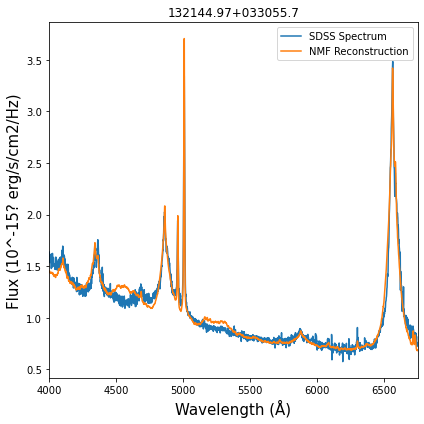

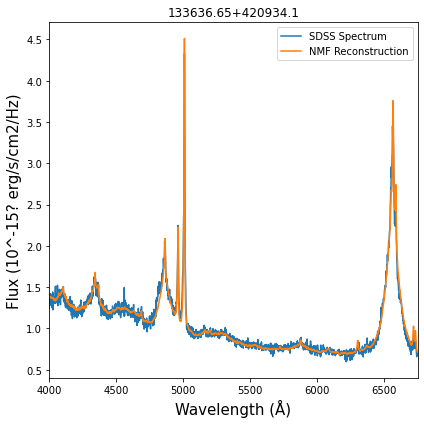

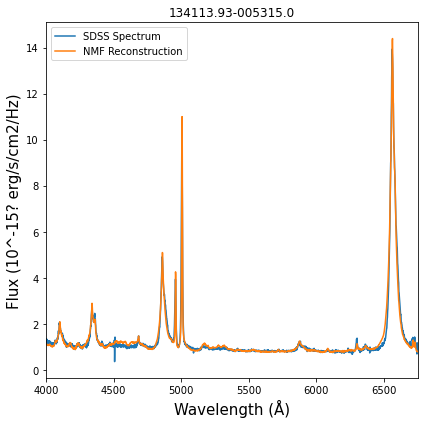

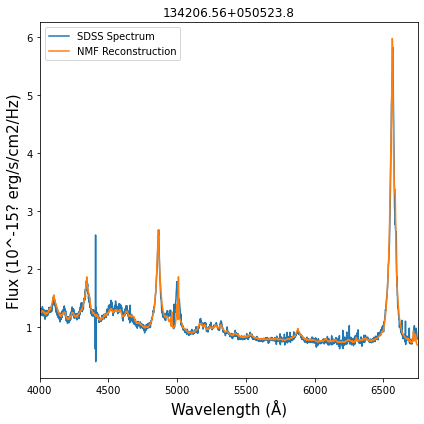

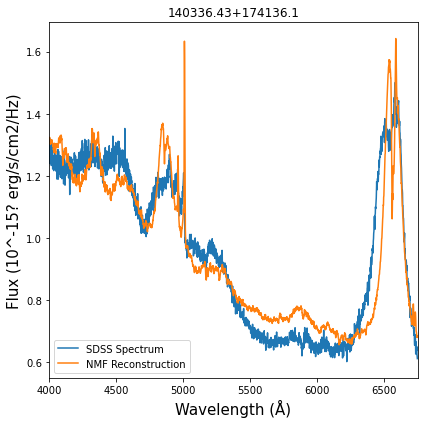

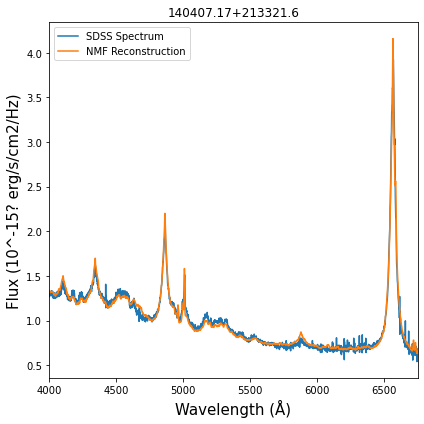

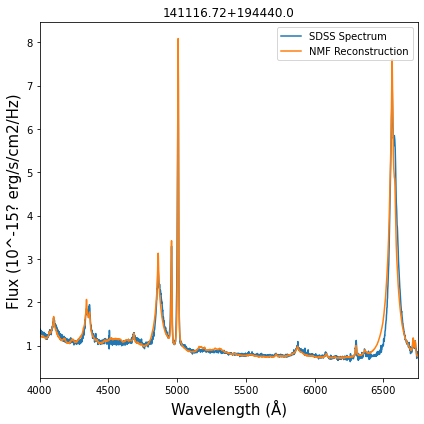

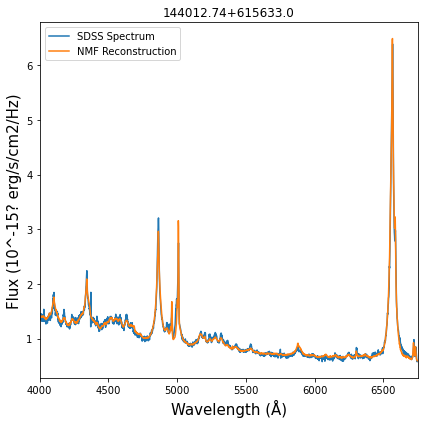

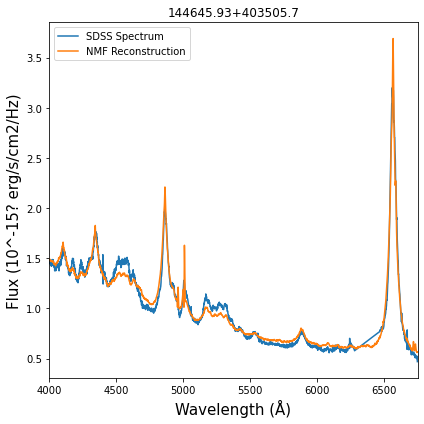

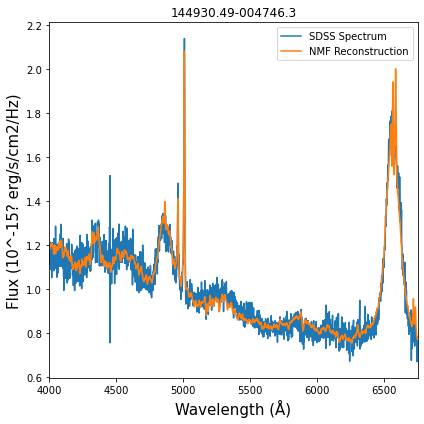

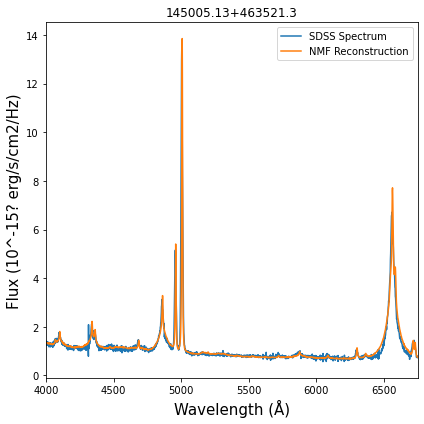

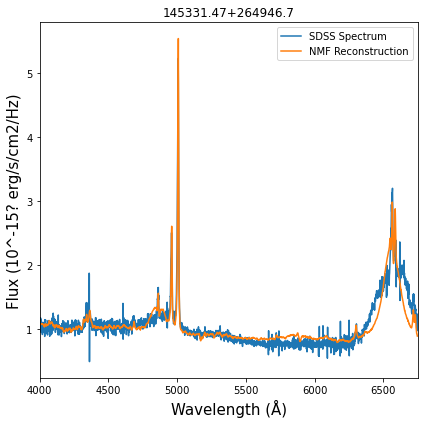

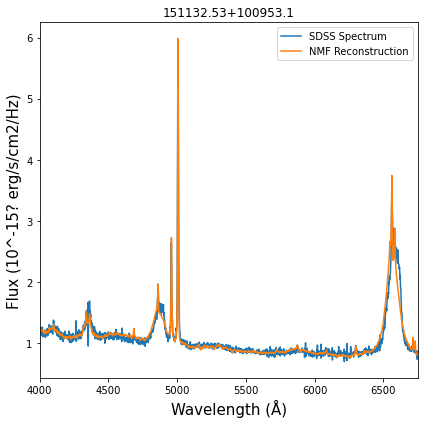

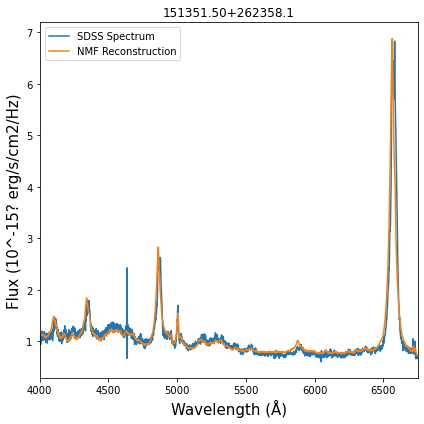

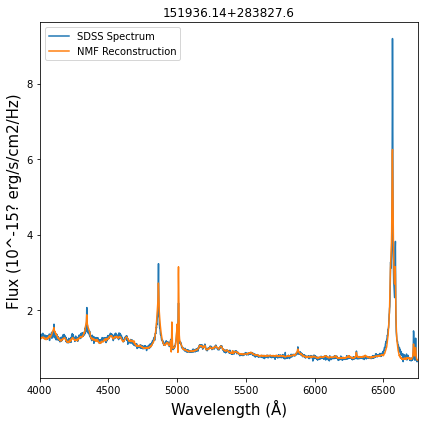

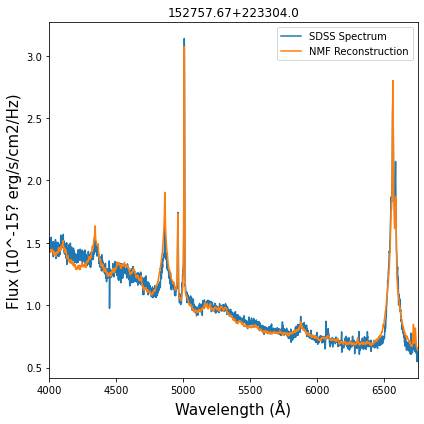

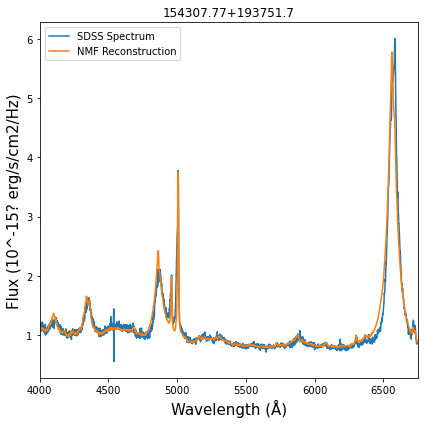

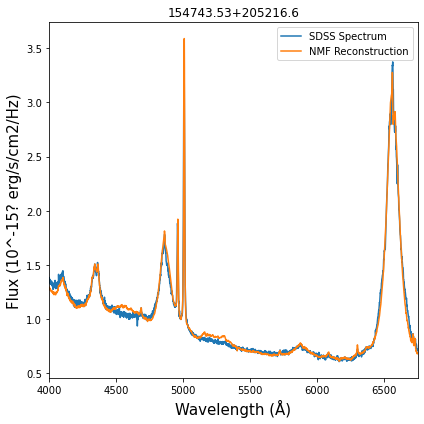

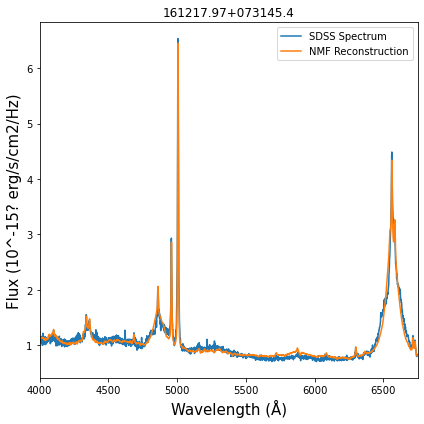

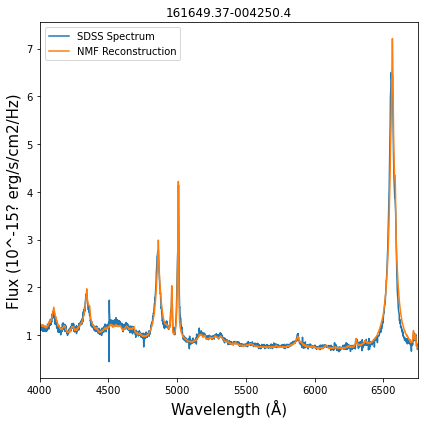

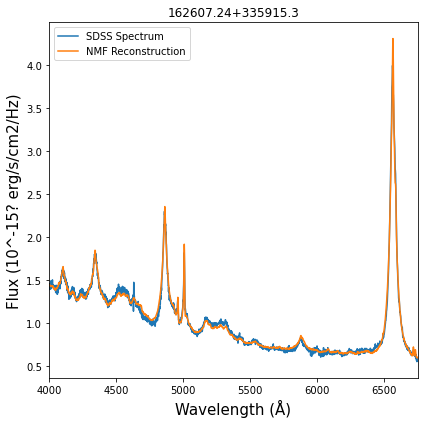

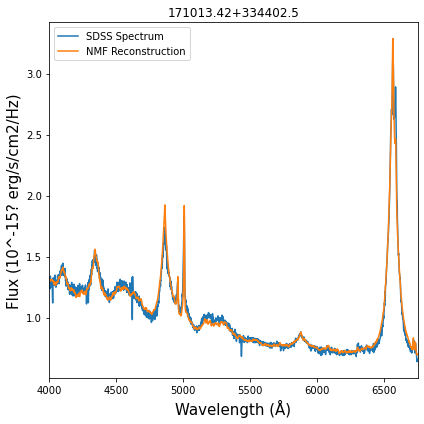

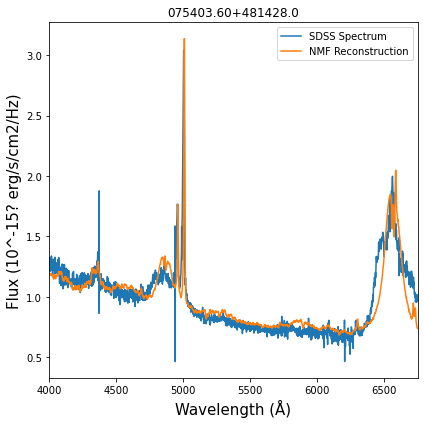

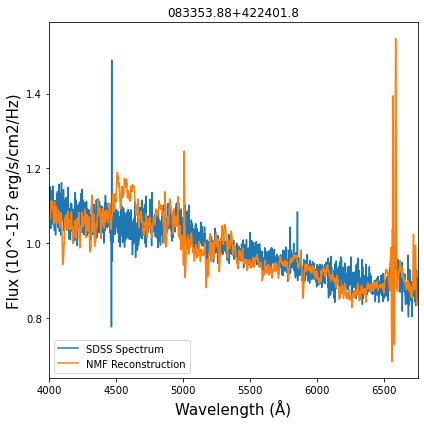

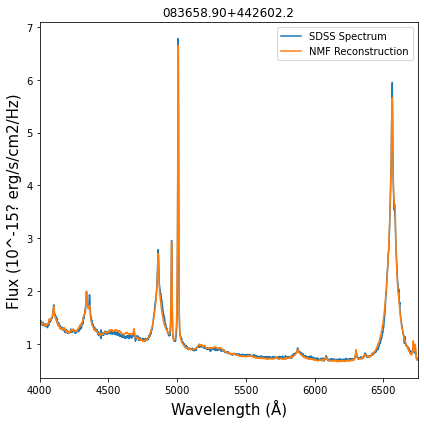

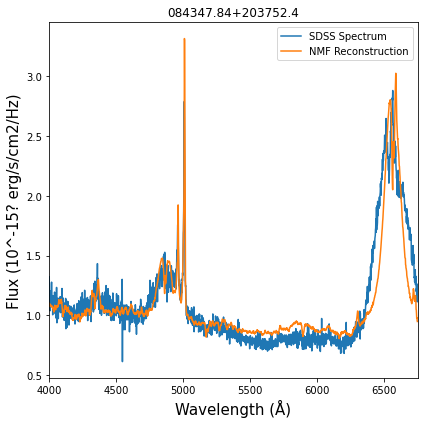

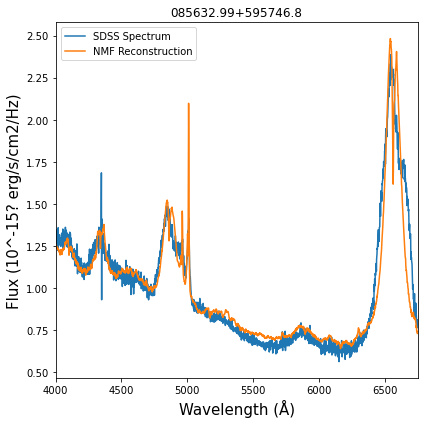

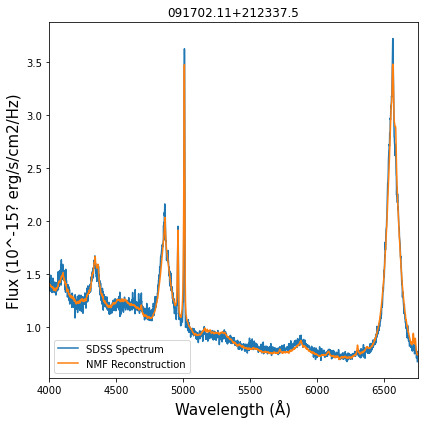

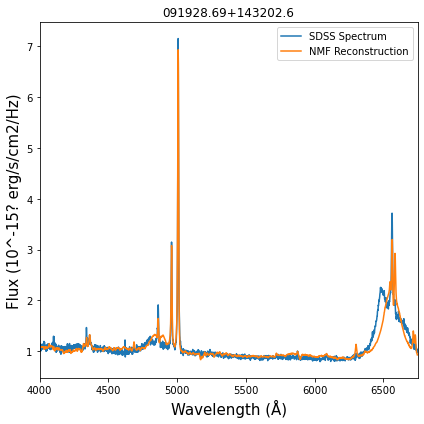

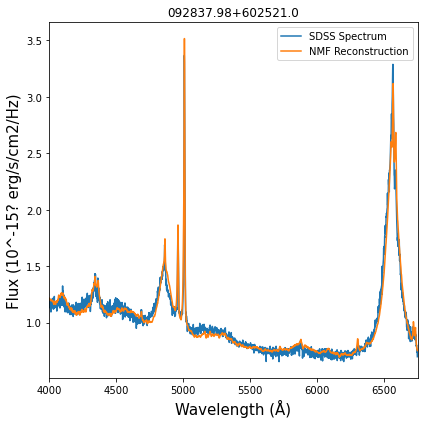

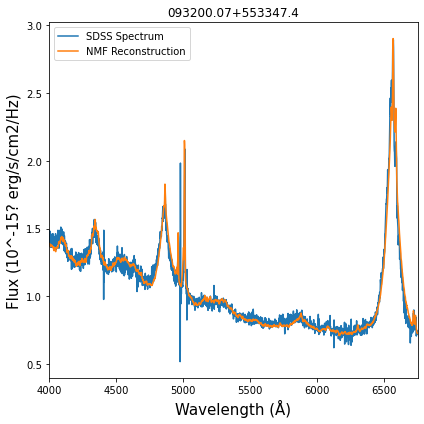

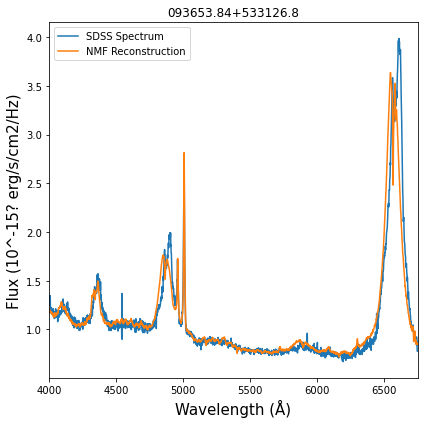

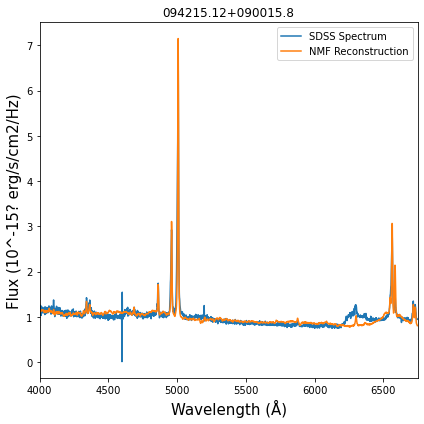

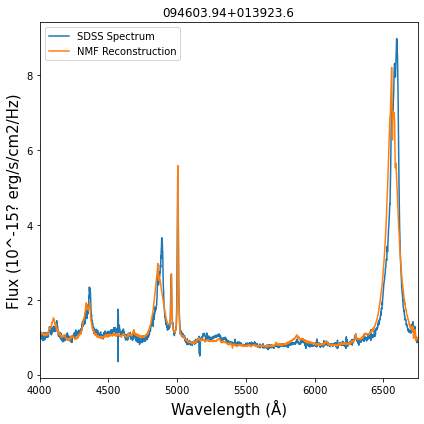

In [246]:
for i in range(len(rqqs)):
    fig = plt.figure(figsize=(6,6))
    plt.plot(wave[0], rqqs[i,:], label="SDSS Spectrum")
    plt.plot(wave[0], np.dot(eigvals_rqqs[i,:], nmf_evecs), label="NMF Reconstruction")
    plt.xlim(4000,6750)
    plt.xlabel("Wavelength (Å)", fontsize=15)
    plt.ylabel("Flux (10^-15? erg/s/cm2/Hz)", fontsize=15)
    plt.title(sdss_names[i])
    plt.legend(loc="best")
    plt.tight_layout()
    plt.savefig("../plots/spectra_plots/MKM2022/%s_wNMF.png"%sdss_names[i])
    plt.show()

In [30]:
# t-SNE
from sklearn.manifold import TSNE
#Not sure what learning_rate does
#tsne2 = TSNE(n_components = 2, learning_rate=100)
tsne2 = TSNE(n_components = 2)
projTSNE2 = tsne2.fit_transform(eigvals_rqqs)
#np.save("tSNE2_Hewett2017.npy", projTSNE2)

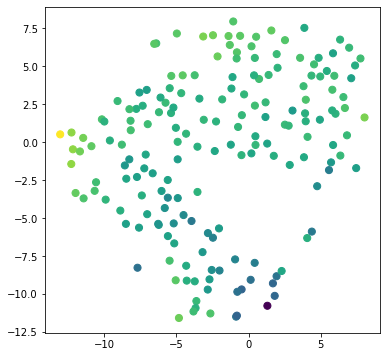

In [31]:
fig = plt.figure(figsize=(6,6))
plt.scatter(projTSNE2[:,0], projTSNE2[:,1], s=50, c=eigvals_rqqs[:,0])
plt.show()

---

Now reconstruct *our spectra* based on this model.

In [32]:
dat.sort_values("A_morph")

A_morph           SDSS_NAME          RA        DEC  REDSHIFT  PLATE  \
0         D  093509.48+481910.2  143.789520  48.319504    0.2238    834   
1         E  152925.98+021646.6  232.358261   2.279618    0.2634   2954   
2         E  144414.66+063306.7  221.061111   6.551877    0.2080   1829   
3         E  140808.19+430316.5  212.034164  43.054600    0.2581   1467   
4         E  172711.80+632242.1  261.799194  63.378372    0.2174    352   
..      ...                 ...         ...        ...       ...    ...   
173     NaN  092837.98+602521.0  142.158264  60.422504    0.2954    485   
174     NaN  093200.07+553347.4  143.000336  55.563171    0.2656    556   
175     NaN  093653.84+533126.8  144.224350  53.524124    0.2281    768   
176     NaN  094215.12+090015.8  145.563034   9.004406    0.2127   1305   
177     NaN  094603.94+013923.6  146.516434   1.656574    0.2203    480   

     FIBER    MJD  TARGET_FLAG_TARGET  NSPECOBS  ...    f_c   logL     i_2  \
0      361  52316                7691         1  ...  1.000  22.92  17.026   
1      379  54561                   3         1  ...  1.000  22.47  17.490   
2      464  53494           135273475         1  ...  1.000  22.47  16.552   
3       48  53115                7171         1  ...  1.000  22.99  16.922   
4      639  51789                7168         2  ...  1.000  22.97  16.730   
..     ...    ...                 ...       ...  ...    ...    ...     ...   
173    506  51909                7173         1  ...  0.104  25.34  17.000   
174    295  51991             2104853         1  ...  1.000  24.01  17.312   
175    473  52281             1048579         1  ...  1.000  22.13  16.465   
176    281  52757                   2         1  ...  1.000  23.15  16.788   
177    480  51989             2097173         1  ...  1.000  23.51  16.373   

      I_2a       R         LD_cm       Lobs   L_1.4GHz  SFR (Msun/yr)  \
0   -22.73    1.07  3.434469e+27  22.949804  23.453667     167.694491   
1   -22.61    0.41  4.120027e+27  22.510854  23.024252      62.388456   
2   -23.04    0.29  3.160119e+27  22.505157  23.005020      59.685944   
3   -23.14    0.85  4.030828e+27  23.028500  23.540693     204.901363   
4   -22.95    0.99  3.313937e+27  23.002030  23.504149     188.365559   
..     ...     ...           ...        ...        ...            ...   
173 -23.35  148.84  4.699743e+27  25.376085  25.897091   46552.449334   
174 -22.81   11.94  4.173728e+27  24.052318  24.566438    2174.153289   
175 -23.32    0.10  3.503693e+27  22.165986  22.670841      27.649846   
176 -22.85    1.66  3.245413e+27  23.186956  23.688075     287.691340   
177 -23.34    2.41  3.365498e+27  23.546181  24.049049     660.543632   

     Separation  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
..          ...  
173         NaN  
174         NaN  
175         NaN  
176         NaN  
177         NaN  

[178 rows x 163 columns]

In [51]:
sdss_names= dat["SDSS_NAME"].values
z         = dat["REDSHIFT"].values
plate     = dat["PLATE"].values
mjd       = dat["MJD"].values
fiber     = dat["FIBER"].values
A_morph = {
    "RL": isNaN(dat["A_morph"].values),
    "U": dat["A_morph"].values=="U",
    "D": dat["A_morph"].values=="D",
    "E": dat["A_morph"].values=="E",
    "M": dat["A_morph"].values=="M",
    "SR":dat["A_morph"].values=="SR",
    "ND":dat["A_morph"].values=="ND"
}

In [34]:
def plot_params(param1, param2):
    fig = plt.figure(figsize=(7,7))
    plt.scatter(eigvals_rqqs[A_morph["U"],param1-1], eigvals_rqqs[A_morph["U"],param2-1], label="U")
    plt.scatter(eigvals_rqqs[A_morph["ND"],param1-1], eigvals_rqqs[A_morph["ND"],param2-1], label="ND")
    #plt.scatter(eigvals_rqqs[A_morph["SR"],param1-1], eigvals_rqqs[A_morph["SR"],param2-1], label="SR")
    plt.scatter(eigvals_rqqs[A_morph["D"],param1-1], eigvals_rqqs[A_morph["D"],param2-1], label="D")
    plt.scatter(eigvals_rqqs[A_morph["E"],param1-1], eigvals_rqqs[A_morph["E"],param2-1], label="E")
    plt.scatter(eigvals_rqqs[A_morph["M"],param1-1], eigvals_rqqs[A_morph["M"],param2-1], label="M")
    plt.scatter(eigvals_rqqs[A_morph["RL"],param1-1], eigvals_rqqs[A_morph["RL"],param2-1], color="pink", label="RL")
    plt.xlabel("Latent Param %d"%param1)
    plt.ylabel("Latent Param %d"%param2)
    plt.legend(loc="best")
    plt.show()

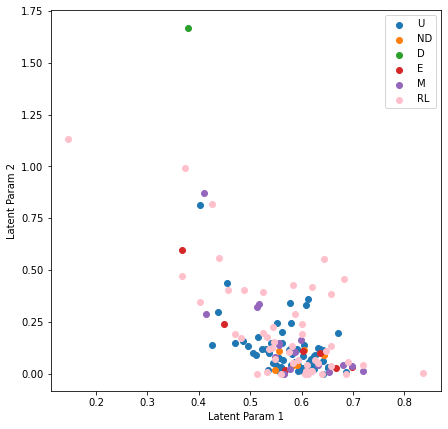

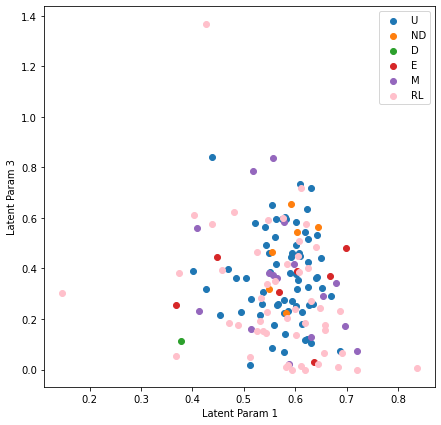

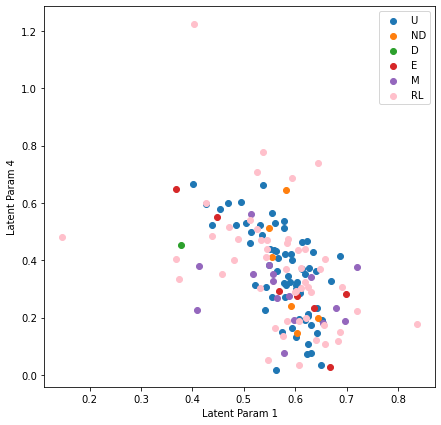

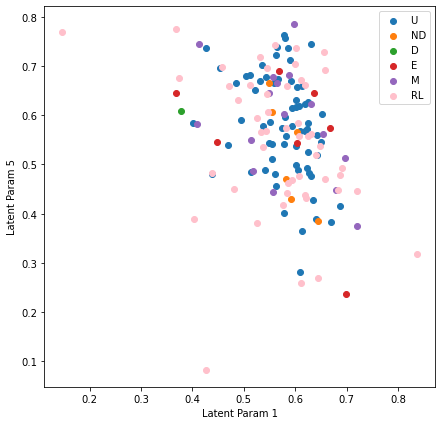

In [35]:
plot_params(1,2)
plot_params(1,3)
plot_params(1,4)
plot_params(1,5)
#plot_params(1,6)

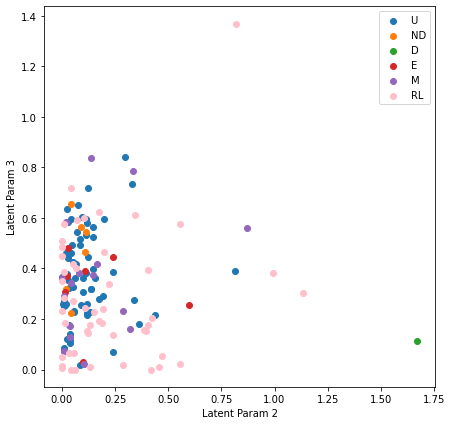

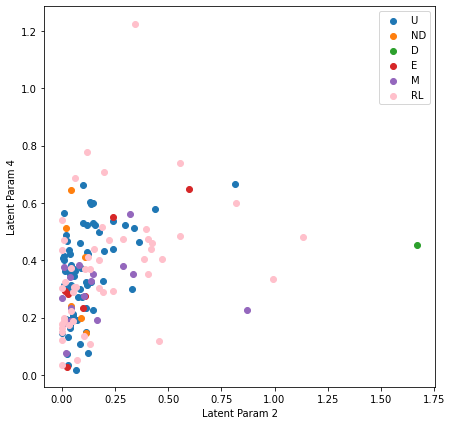

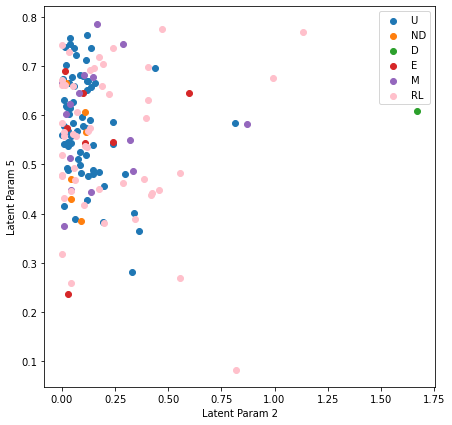

In [36]:
plot_params(2,3)
plot_params(2,4)
plot_params(2,5)
#plot_params(2,6)

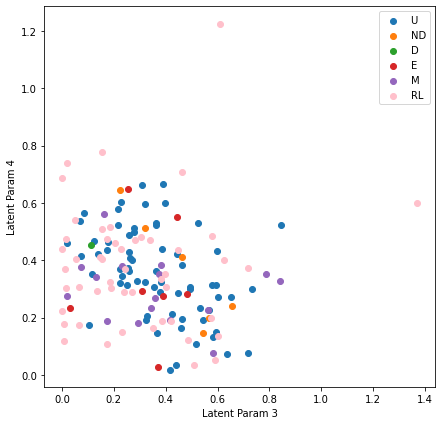

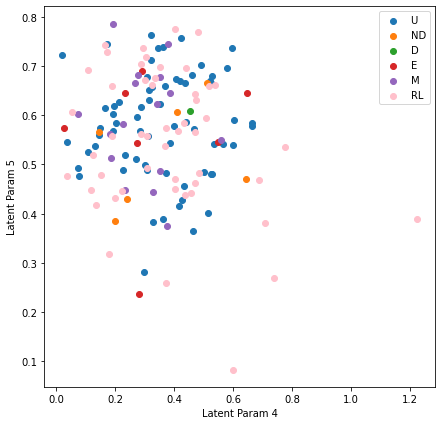

In [37]:
plot_params(3, 4)
plot_params(4,5)

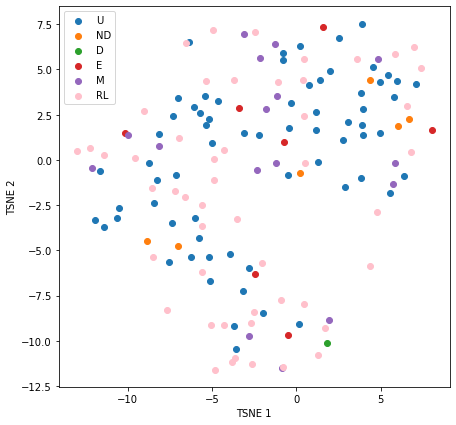

In [38]:
fig = plt.figure(figsize=(7,7))
plt.scatter(projTSNE2[A_morph["U"],0], projTSNE2[A_morph["U"],1], label="U")
plt.scatter(projTSNE2[A_morph["ND"],0], projTSNE2[A_morph["ND"],1], label="ND")
#plt.scatter(projTSNE2[A_morph["SR"],0], projTSNE2[A_morph["SR"],1], label="SR")
plt.scatter(projTSNE2[A_morph["D"],0], projTSNE2[A_morph["D"],1], label="D")
plt.scatter(projTSNE2[A_morph["E"],0], projTSNE2[A_morph["E"],1], label="E")
plt.scatter(projTSNE2[A_morph["M"],0], projTSNE2[A_morph["M"],1], label="M")
plt.scatter(projTSNE2[A_morph["RL"],0], projTSNE2[A_morph["RL"],1], color="pink", label="RL")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.legend(loc="best")
plt.show()

----

Now just make some line measurements.  My hypothesis is that objects with low $H\alpha$ and high $OIII$ are more likely to be RL (or RQ with radio originating from the AGN).

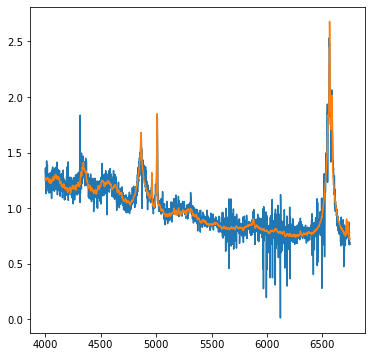

In [39]:
fig = plt.figure(figsize=(6,6))
plt.plot(wave[0], rqqs[9,:])
plt.plot(wave[0], np.dot(eigvals_rqqs[9,:], nmf_evecs))
plt.show()

In [201]:
def blueshift(labwave, wave_half_flux):
    return ((labwave - wave_half_flux) / labwave) * 3e5 #for line

def get_line(wave, flux, reconstruction, name, linename="Halpha"):
    #Going to save plots, but not show with magic above
    if linename == "Halpha":
        xlims = 6350,6750
        yplotmask = ((wave>6400) & (wave<6750)) #get ylims using this wavelength range
        waverange = [6430,6685] #sum flux between these wavelengths
        labwave = 6564.61
        cont1 = ((wave>=6380)&(wave<=6400))
        cont2 = ((wave>=6695)&(wave<=6700))
    elif linename == "OIII_5008":
        xlims = 4975,5040
        yplotmask = ((wave>4980) & (wave<5030)) #get ylims using this wavelength range
        waverange = [4990,5025] #sum flux between these wavelengths
        labwave = 5008.240
        cont1 = ((wave>=4980)&(wave<=4985))
        cont2 = ((wave>=5025)&(wave<=5035))
    elif linename == "OIII_4960":
        xlims = 4930,4980
        yplotmask = ((wave>4940) & (wave<4980)) #get ylims using this wavelength range
        waverange = [4950,4970] #sum flux between these wavelengths
        labwave = 4960.295
        cont1 = ((wave>=4930)&(wave<=4940))
        cont2 = ((wave>=4975)&(wave<=4980))
    elif linename == "Hbeta":
        xlims = 4750,4950
        yplotmask = ((wave>4750) & (wave<4950)) #get ylims using this wavelength range
        waverange = [4800,4925] #sum flux between these wavelengths
        labwave = 4862.68
        cont1 = ((wave>=4750)&(wave<=4775))
        cont2 = ((wave>=4925)&(wave<=4945))
    elif linename == "Hgamma":
        xlims = 4250,4450
        yplotmask = ((wave>4250) & (wave<4450)) #get ylims using this wavelength range
        waverange = [4300,4390] #sum flux between these wavelengths
        labwave = 4341.68
        cont1 = ((wave>=4250)&(wave<=4270))
        cont2 = ((wave>=4425)&(wave<=4445))
    
    fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(16,6))
    ax1.plot(wave, flux)
    #ax1.plot(wave, reconstruction, label="NMF Reconstruction")
    ax1.plot([labwave,labwave], [min(reconstruction[yplotmask])-.1, max(reconstruction[yplotmask])+.1], "--k", label="Laboratory Wavelength - %s"%linename)
    
    
    #Fit continuum
    
    ax1.axvspan(min(wave[cont1]), max(wave[cont1]), alpha=0.5, color='grey')
    ax1.axvspan(min(wave[cont2]), max(wave[cont2]), alpha=0.5, color='grey')
    
    m,b = np.polyfit(np.concatenate((wave[cont1], wave[cont2])), np.concatenate((reconstruction[cont1], reconstruction[cont2])), 1)
    continuum = wave*m + b
    ax1.plot(wave, continuum, "-r", label="Power-law Continuum")
    
    #Plot EW region under reconstruction
    EW = ((wave>=waverange[0])&(wave<=waverange[1]))
    #ax1.fill_between(wave[EW], continuum[EW], reconstruction[EW], color="blue", alpha=0.2)
    ax1.fill_between(wave[EW], continuum[EW], flux[EW], color="blue", alpha=0.2)
    
    #And compute the EW
    line_EW = 0
    ew_list = [0.]
    for i in range(len(wave[EW])):
        try:
            #line_EW += max(( (reconstruction[EW][i] - continuum[i]) / continuum[i] ) * ( wave[EW][i+1] - wave[EW][i] ), 0) #no negative fluxes
            line_EW += max(( (flux[EW][i] - continuum[EW][i]) / continuum[EW][i] ) * ( wave[EW][i+1] - wave[EW][i] ), 0)
        except IndexError:
            #line_EW += max(( (reconstruction[EW][i] - continuum[EW][i]) / continuum[EW][i] ) * ( wave[EW][i] - wave[EW][i-1] ), 0)
            line_EW += max(( (flux[EW][i] - continuum[EW][i]) / continuum[EW][i] ) * ( wave[EW][i] - wave[EW][i-1] ), 0)

        ew_list.append(line_EW)
    
    ind_half_flux = abs((line_EW / 2) - np.array(ew_list)).argmin()
    line_shift = blueshift(labwave, wave[EW][ind_half_flux])
    
    if line_shift>=0:
        ax1.plot([wave[EW][ind_half_flux],wave[EW][ind_half_flux]], [min(reconstruction[yplotmask])-.1, max(reconstruction[yplotmask])+.1], "--b", label="Observed Shift = %.2f km/s, EW = %.2f Å" % (line_shift, line_EW))
        ax2.plot([wave[EW][ind_half_flux], wave[EW][ind_half_flux]], [0,1], "--b")
        ax2.plot(waverange, [0.5,0.5], "--b")
    else:
        ax1.plot([wave[EW][ind_half_flux],wave[EW][ind_half_flux]], [min(reconstruction[yplotmask])-.1, max(reconstruction[yplotmask])+.1], "--r", label="Observed Shift = %.2f km/s, EW = %.2f Å" % (line_shift, line_EW))
        ax2.plot([wave[EW][ind_half_flux], wave[EW][ind_half_flux]], [0,1], "--r")
        ax2.plot(waverange, [0.5,0.5], "--r")
        
    ax2.plot(wave[EW], np.array(ew_list[:-1])/line_EW)
    ax2.set_xlim(waverange)
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("Fraction of total EW", fontsize=15)
    ax2.set_xlabel("Wavelength (Å)", fontsize=15)
    
    ax1.set_xlim(xlims)
    ax1.set_ylim(min(reconstruction[yplotmask])-.1, max(reconstruction[yplotmask])+.1)
    ax1.set_ylabel("Flux (Arbitrary Units)", fontsize=15)
    ax1.set_xlabel("Wavelength (Å)", fontsize=15)
    ax1.set_title("%s - EW = %.2f Å"%(name, line_EW), fontsize=15)
    ax1.legend(loc="best")
    plt.tight_layout()
    plt.savefig("../plots/line_measurements/MKM2022/%s/%s_NMF6comp_%s.png"%(linename, name, linename))
    plt.show()
    
        
    return line_shift, line_EW
    #return line_EW

In [163]:
%%capture
EW_Halpha = []
shift_Halpha = []
for i in range(len(rqqs)):
    shift_Ha, ew_Ha = get_line(wave[i], rqqs[i], reconstructions_rqqs[i], sdss_names[i], linename="Halpha")
    EW_Halpha.append(ew_Ha)
    shift_Halpha.append(shift_Ha)
EW_Halpha = np.array(EW_Halpha)
shift_Halpha = np.array(shift_Halpha)

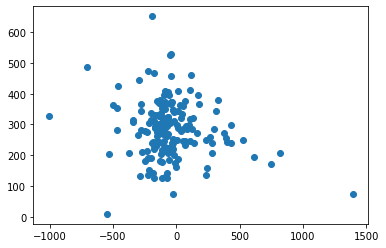

In [155]:
plt.scatter(shift_Halpha, EW_Halpha)

In [107]:
reconstructions_rqqs = np.dot(eigvals_rqqs, nmf_evecs)

Now do the same for OIII

In [174]:
%%capture
EW_OIII5008 = []
shift_OIII5008 = []
for i in range(len(rqqs)):
    shift_oiii, ew_oiii = get_line(wave[i], rqqs[i], reconstructions_rqqs[i], sdss_names[i], linename="OIII_5008")
    EW_OIII5008.append(ew_oiii)
    shift_OIII5008.append(shift_oiii)
EW_OIII5008 = np.array(EW_OIII5008)
shift_OIII5008 = np.array(shift_OIII5008)

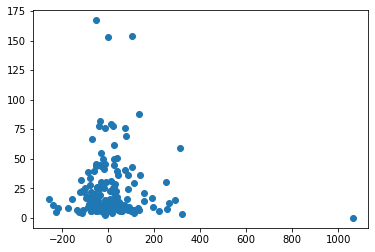

In [175]:
plt.scatter(shift_OIII5008, EW_OIII5008)

In [182]:
%%capture
EW_OIII4960 = []
shift_OIII4960 = []
for i in range(len(rqqs)):
    shift_oiii, ew_oiii = get_line(wave[i], rqqs[i], reconstructions_rqqs[i], sdss_names[i], linename="OIII_4960")
    EW_OIII4960.append(ew_oiii)
    shift_OIII4960.append(shift_oiii)
EW_OIII4960 = np.array(EW_OIII4960)
shift_OIII4960 = np.array(shift_OIII4960)

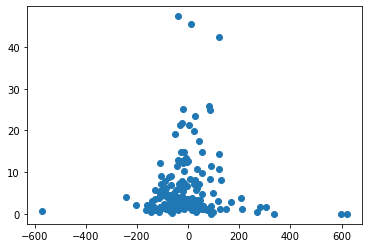

In [183]:
plt.scatter(shift_OIII4960, EW_OIII4960)

In [194]:
%%capture
EW_Hbeta = []
shift_Hbeta = []
for i in range(len(rqqs)):
    shift_Hb, ew_Hb = get_line(wave[i], rqqs[i], reconstructions_rqqs[i], sdss_names[i], linename="Hbeta")
    EW_Hbeta.append(ew_Hb)
    shift_Hbeta.append(shift_Hb)
EW_Hbeta = np.array(EW_Hbeta)
shift_Hbeta = np.array(shift_Hbeta)

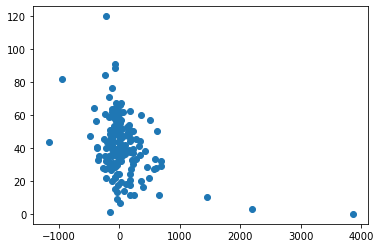

In [195]:
plt.scatter(shift_Hbeta, EW_Hbeta)

In [202]:
%%capture
EW_Hgamma = []
shift_Hgamma = []
for i in range(len(rqqs)):
    shift_Ha, ew_Ha = get_line(wave[i], rqqs[i], reconstructions_rqqs[i], sdss_names[i], linename="Hgamma")
    EW_Hgamma.append(ew_Ha)
    shift_Hgamma.append(shift_Ha)
EW_Hgamma = np.array(EW_Hgamma)
shift_Hgamma = np.array(shift_Hgamma)

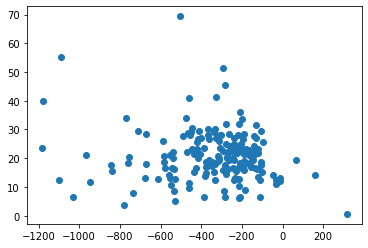

In [203]:
plt.scatter(shift_Hgamma, EW_Hgamma)

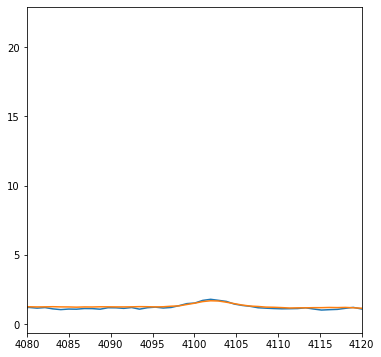

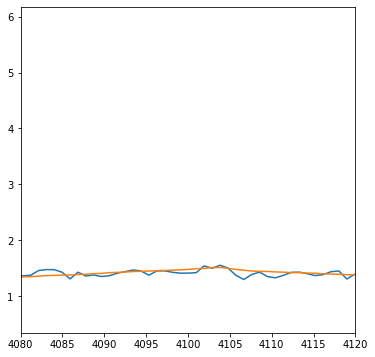

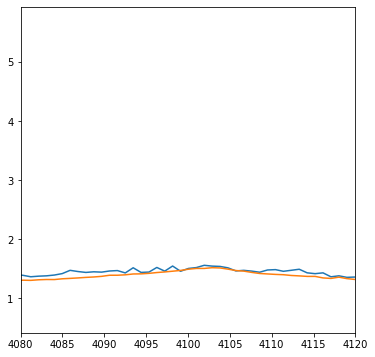

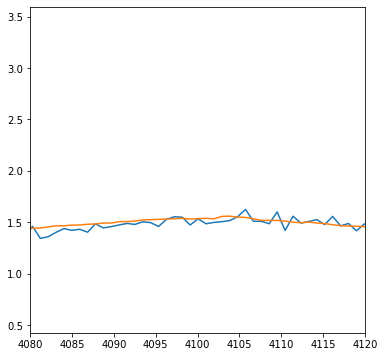

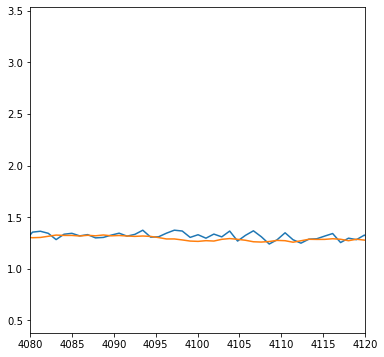

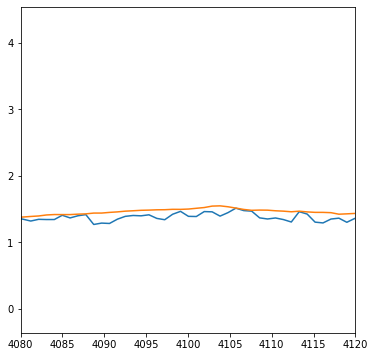

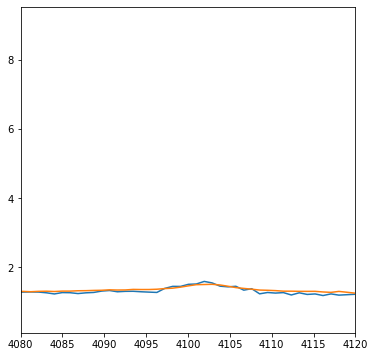

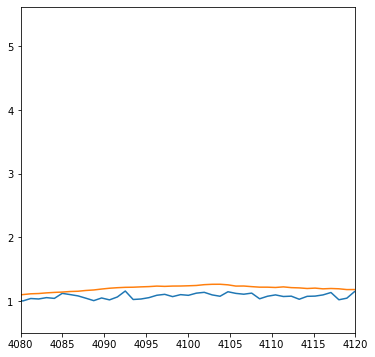

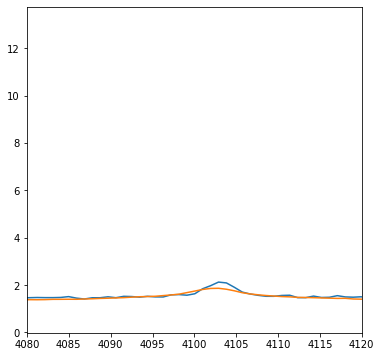

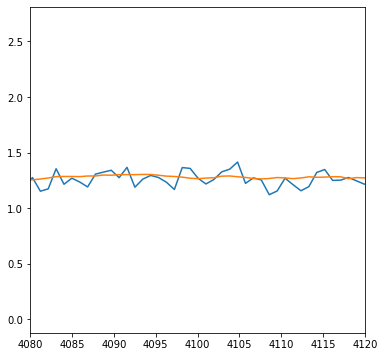

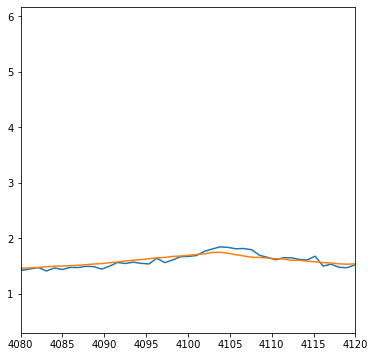

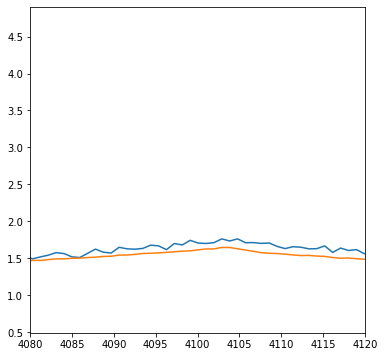

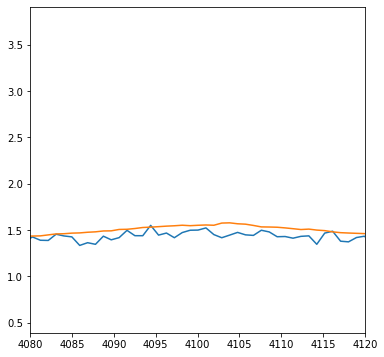

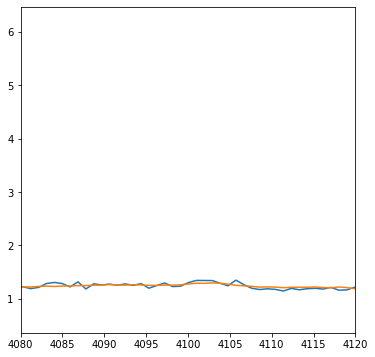

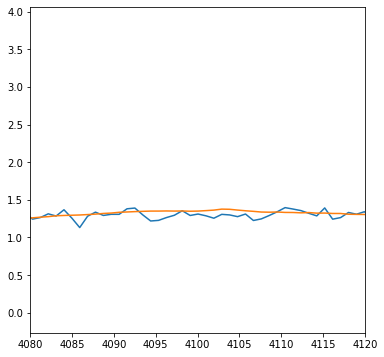

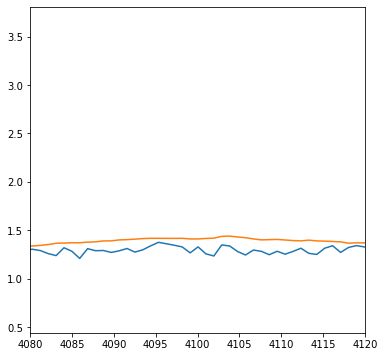

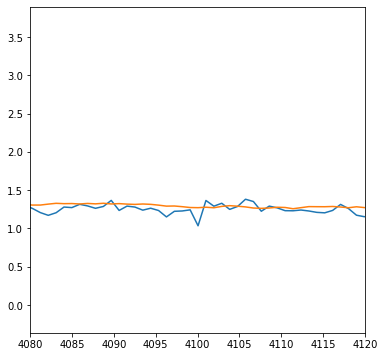

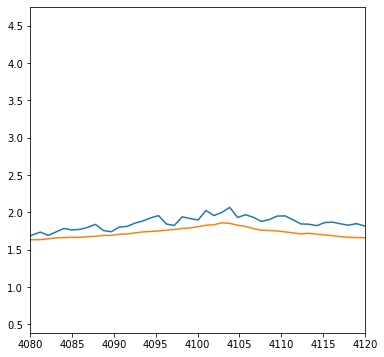

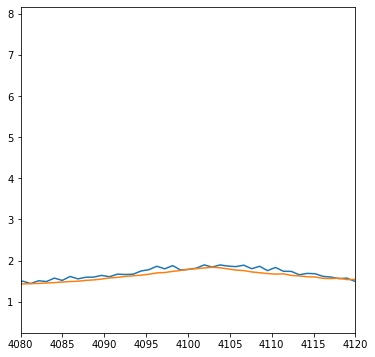

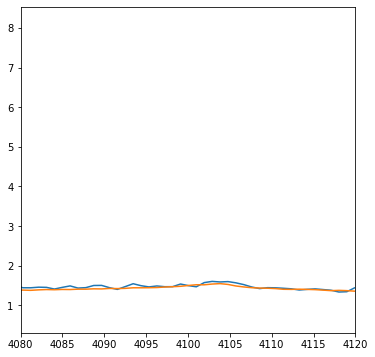

In [206]:
"""elif linename == "Hgamma":
    xlims = 4250,4450
    yplotmask = ((wave>4250) & (wave<4450)) #get ylims using this wavelength range
    waverange = [4300,4390] #sum flux between these wavelengths
    labwave = 4341.68
    cont1 = ((wave>=4250)&(wave<=4270))
    cont2 = ((wave>=4425)&(wave<=4445))

"""
for i in range(20):
    fig = plt.figure(figsize=(6,6))
    plt.plot(wave[0], rqqs[i,:])
    plt.plot(wave[0], np.dot(eigvals_rqqs[i,:], nmf_evecs))
    plt.xlim(4080,4120)
    plt.show()

Don't save $H\Delta$ -- too faint for most to even measure.  Now want to see how combinations of these line paramters correlate with radio properties.

In [237]:
def plot_corrs(param1, param2):
    fig = plt.figure(figsize=(7,7))
    plt.scatter(param1[A_morph["U"]], param2[A_morph["U"]], label="U")
    plt.scatter(param1[A_morph["ND"]], param2[A_morph["ND"]], label="ND")
    #plt.scatter(param1[A_morph["SR"]], param2[A_morph["SR"]], label="SR")
    plt.scatter(param1[A_morph["D"]], param2[A_morph["D"]], label="D")
    plt.scatter(param1[A_morph["E"]], param2[A_morph["E"]], label="E")
    plt.scatter(param1[A_morph["M"]], param2[A_morph["M"]], label="M")
    plt.scatter(param1[A_morph["RL"]], param2[A_morph["RL"]], color="pink", label="RL")
    plt.xlabel("Param 1")
    plt.ylabel("Param 2")
    plt.legend(loc="best")
    plt.show()
def plot_corrs_simple(param1, param2):
    fig = plt.figure(figsize=(7,7))
    plt.scatter(param1[A_morph["U"]|A_morph["ND"]], param2[A_morph["U"]|A_morph["ND"]], label="U")
    plt.scatter(param1[A_morph["RL"]|((~A_morph["U"])&(~A_morph["ND"]))], param2[A_morph["RL"]|((~A_morph["U"])&(~A_morph["ND"]))], color="pink", label="RL/R")
    plt.xlabel("Param 1")
    plt.ylabel("Param 2")
    plt.legend(loc="best")
    plt.show()

<ipython-input-236-6f31fbdeba2b>:1: RuntimeWarning: divide by zero encountered in log10
  plot_corrs(EW_Halpha, np.log10(EW_OIII5008))


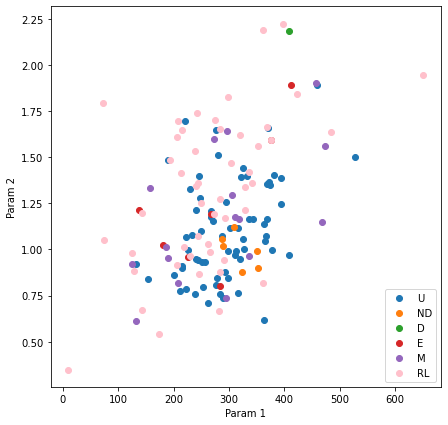

In [236]:
plot_corrs(EW_Halpha, np.log10(EW_OIII5008))

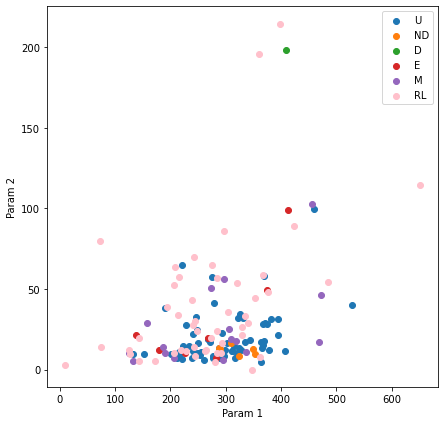

In [213]:
plot_corrs(EW_Halpha, EW_OIII5008+EW_OIII4960)

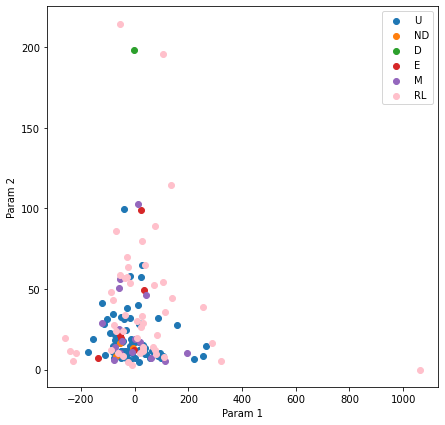

In [218]:
plot_corrs(shift_OIII5008, EW_OIII5008+EW_OIII4960)

<ipython-input-224-09126675480f>:1: RuntimeWarning: invalid value encountered in true_divide
  plot_corrs(shift_Halpha, np.log10((EW_OIII5008+EW_OIII4960)/EW_Hbeta))


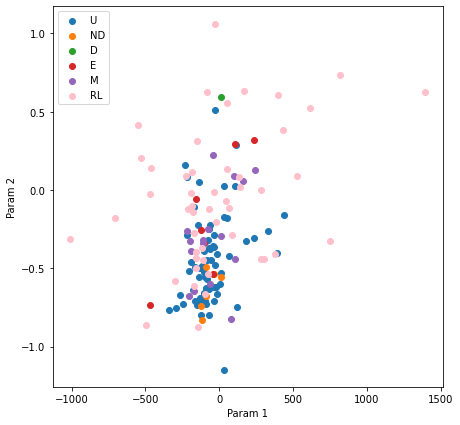

In [224]:
plot_corrs(shift_Halpha, np.log10((EW_OIII5008+EW_OIII4960)/EW_Hbeta))

<ipython-input-232-c05a209aa39b>:1: RuntimeWarning: invalid value encountered in true_divide
  plot_corrs(shift_OIII5008, np.log10((EW_OIII5008+EW_OIII4960)/EW_Hbeta))


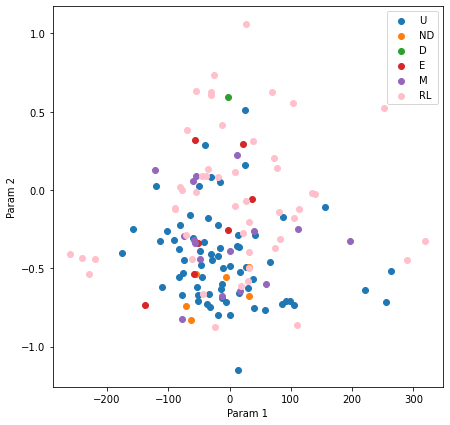

In [232]:
plot_corrs(shift_OIII5008, np.log10((EW_OIII5008+EW_OIII4960)/EW_Hbeta))

<ipython-input-238-6ec44606b952>:1: RuntimeWarning: invalid value encountered in true_divide
  plot_corrs_simple(shift_OIII5008, np.log10((EW_OIII5008+EW_OIII4960)/EW_Hbeta))


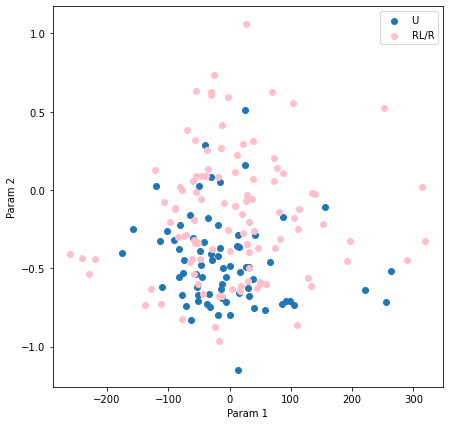

In [238]:
plot_corrs_simple(shift_OIII5008, np.log10((EW_OIII5008+EW_OIII4960)/EW_Hbeta))

RLs definitely outnumber RQs in area of this parameter space.  Interesting that the one "double" RQ is in that same area, along with 3/6 extended RQs, are in that same area of parameter space.  The faintest nondetections (orange points) are also all bunched together.  I suspect that the RLs that don't follow the same trends are generally still Unresolved in FIRST.

We could pretty much draw a diagonal line through these data, and say that all above it likely have AGN-related radio.  

Let's create a nice Bokeh plot which incorporates the images and other radio data that we have. 

In [239]:
dat["SHIFT_OIII"] = shift_OIII5008

In [240]:
dat.to_csv("../data/ParentSample_DR7props.csv")